<font size=5><b>Прогнозирование оттока клиентов Телеком компании</b></font>

## Описание задачи

Необходимо создать модель по прогнозированию оттока клиентов для компании «Ниединогоразрыва.ком». В случае, если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 
По собранным данным о некоторых клиентах, информации об их тарифах и договорах необходимо обучить модели для прогнозирования факта ухода клиента. 

### План работы

Просмотр исходных данных о клиентах и их контрактах, состоящих из четырех датасетов.

Исследовательский анализ данных:

-приведение столбцов к змеиному регистру,
-просмотр на наличие пропусков в данных и выбросов,
-добавление новых столбов при необходимости,
-изменение типов данных,
-просмотр распределения данных,
-удаление столбцов, не несущих смысловую нагрузку,
-склеивание всех таблиц в единую таблицу.

Предобработка данных перед обучением:

-кодирование категориальных признаков,
-разделение данных на фичи и таргет (классы должны быть сбалансированы),
-разбиение на обучающую и тестовую выборки,
-масштабирование фичей,
-проверить признаки на наличие корреляции.

Обучение моделей:

-использование следующих ML моделей: RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, LGBMClassifier, CatBoostClassifier, XGBClassifier
-поиск лучших гиперпараметров моделей с помощью RandomizedSearchCV либо GridSearchCV.

Проверка лучших моделей на тестовой выборке:

-сравнение полученных результатов с базовой моделью,
-построение таблиц важности признаков.

Выводы


## Исследовательский анализ данных

### Первичный просмотр 

Импортируем необходимые библиотеки

In [1]:
!pip install sweetviz -q
!pip install phik
!pip install pandas_profiling

In [2]:
import numpy as np
import pandas as pd
import torch
import transformers
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.utils import shuffle
import re 
import seaborn as sns
import time

from scipy import stats as st

from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score,  roc_auc_score, roc_curve,  make_scorer, confusion_matrix, recall_score
from sklearn.metrics import accuracy_score, precision_score

import catboost as ctb
import xgboost as xgb
import lightgbm as ltb

import sweetviz as sv
import pandas_profiling

In [3]:
%matplotlib inline

Загрузим имеющиеся датасеты по-очереди, посмотрим первые 5 строк и информацию о них.

#### Contract

В качестве индекса будем использовать CustomerID.

In [4]:
# для открытия файла используем два варианта: для работы на платформе и локально
def read_csv_file(path):
    
    # для работы локально
    try:
        return pd.read_csv(path, index_col= 0)
    
    # для работы на платформе 
    except:
        return pd.read_csv('/datasets/final_provider/'+path, index_col= 0)

In [5]:
path = 'contract.csv'
df_contract = read_csv_file(path)
print(df_contract.info())
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB
None


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Посмотрим даты начала контракта. 

In [6]:
df_contract.BeginDate.value_counts().sort_index()

2013-10-01      3
2013-11-01      2
2013-12-01      3
2014-01-01      7
2014-02-01    366
             ... 
2019-10-01    237
2019-11-01    237
2019-12-01    220
2020-01-01    233
2020-02-01     11
Name: BeginDate, Length: 77, dtype: int64

Видим, что первые контракты были 2013-10-01, а последние 2020-02-01.

В этом датасете внимание привлекает столбец 'EndDate' - судя по всему это и есть факт ухода клиента (конец контракта). 
Создадим новый столбец Churn - наш будущий целевой признак, который будет содержать факт ухода клиента. 0 - не ушел, 1 - ушел.

In [7]:
df_contract['churn'] = df_contract['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

In [8]:
df_contract

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn
customerID,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,0
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,0
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,0


Посмотрим уникальные значения даты ухода. 

In [9]:
df_contract.EndDate.value_counts(dropna = False)

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

Видим, что расторжения начались с октября 2019 года и далее каждый месяц видим уход клиентов примерно в одинаковом количестве. Интересно, с чем это связано? что-то произошло к октябрю 2019го, что клиенты начали уходить?

Посмотрим, сколько расторгнутых контрактов на 1 февраля 2020 года (как указано в условии)

In [10]:
len(df_contract)-df_contract.EndDate.value_counts(dropna = False)[0]

1869

Видим, что большая часть 5174 контракта все еще действуют, а остальные - 1869 уже растрогнуты. 

Установим вместо No дату 1 февраля 2020 года и переведем оба столбца EndDate и BeginDate к типу datetime

In [11]:
df_contract.loc[df_contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
df_contract['EndDate'] = df_contract['EndDate'].astype('datetime64')
df_contract.BeginDate = pd.to_datetime(df_contract.BeginDate)

Проверим корректность работы кода

In [12]:
df_contract.EndDate.value_counts(dropna = False)

2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: EndDate, dtype: int64

In [13]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
 7   churn             7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 495.2+ KB


Создадим столбец days, содержащий количество дней действия контракта. 

In [14]:
df_contract['days'] = (df_contract['EndDate'] - df_contract['BeginDate'])

In [15]:
df_contract.days = df_contract.days.apply(lambda x: x.days)

In [16]:
df_contract

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,days
customerID,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0,1036
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61
...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.5,0,730
2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.9,0,2191
4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,337


#### Phone

In [17]:
path = 'phone.csv'
df_phone = read_csv_file(path)
print(df_phone.info())
df_phone.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB
None


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


Видим, что услугами телефонии пользуются не все клиенты. MultipleLines - это наличие возможности ведения паралельных линий во время звонка.

In [18]:
df_phone.value_counts()

MultipleLines
No               3390
Yes              2971
dtype: int64

Пока ничего делать не будем с этим датасетом.

#### Internet

In [19]:
path = 'internet.csv'
df_internet = read_csv_file(path)
print(df_internet.info())
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB
None


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


Видим, что услугами интернета пользуются не все клиенты. Посмотрим, какие значения в столбце 'InternetService'.

In [20]:
df_internet.InternetService.value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

На мой взгляд, столбцы этого датасета могут иметь значение для будущих моделей, поэтому пока удалять ничего не будем.

#### Personal

In [21]:
path = 'personal.csv'
df_personal = read_csv_file(path)
print(df_personal.info())
df_personal.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB
None


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


#### Общий датасет

Склеим имеющиеся у нас датасеты, так, чтоб получить общую картину по всем клиентам. 

In [22]:
df = df_personal.join(df_contract, how = 'right')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            7043 non-null   object        
 1   SeniorCitizen     7043 non-null   int64         
 2   Partner           7043 non-null   object        
 3   Dependents        7043 non-null   object        
 4   BeginDate         7043 non-null   datetime64[ns]
 5   EndDate           7043 non-null   datetime64[ns]
 6   Type              7043 non-null   object        
 7   PaperlessBilling  7043 non-null   object        
 8   PaymentMethod     7043 non-null   object        
 9   MonthlyCharges    7043 non-null   float64       
 10  TotalCharges      7043 non-null   object        
 11  churn             7043 non-null   int64         
 12  days              7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(7)
memory usage: 

In [23]:
df = df.join(df_internet, how = 'left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            7043 non-null   object        
 1   SeniorCitizen     7043 non-null   int64         
 2   Partner           7043 non-null   object        
 3   Dependents        7043 non-null   object        
 4   BeginDate         7043 non-null   datetime64[ns]
 5   EndDate           7043 non-null   datetime64[ns]
 6   Type              7043 non-null   object        
 7   PaperlessBilling  7043 non-null   object        
 8   PaymentMethod     7043 non-null   object        
 9   MonthlyCharges    7043 non-null   float64       
 10  TotalCharges      7043 non-null   object        
 11  churn             7043 non-null   int64         
 12  days              7043 non-null   int64         
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity

In [24]:
df = df.join(df_phone, how = 'left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            7043 non-null   object        
 1   SeniorCitizen     7043 non-null   int64         
 2   Partner           7043 non-null   object        
 3   Dependents        7043 non-null   object        
 4   BeginDate         7043 non-null   datetime64[ns]
 5   EndDate           7043 non-null   datetime64[ns]
 6   Type              7043 non-null   object        
 7   PaperlessBilling  7043 non-null   object        
 8   PaymentMethod     7043 non-null   object        
 9   MonthlyCharges    7043 non-null   float64       
 10  TotalCharges      7043 non-null   object        
 11  churn             7043 non-null   int64         
 12  days              7043 non-null   int64         
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity

In [25]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'BeginDate',
       'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'churn', 'days', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

In [26]:
df.columns = [re.sub(r"(\w)([A-Z])", r"\1 \2", col) for col in df.columns]
df.columns = df.columns.str.lower().str.replace(' ','_')

In [27]:
df.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'begin_date',
       'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'churn', 'days', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

##### Обработка пропусков

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   gender             7043 non-null   object        
 1   senior_citizen     7043 non-null   int64         
 2   partner            7043 non-null   object        
 3   dependents         7043 non-null   object        
 4   begin_date         7043 non-null   datetime64[ns]
 5   end_date           7043 non-null   datetime64[ns]
 6   type               7043 non-null   object        
 7   paperless_billing  7043 non-null   object        
 8   payment_method     7043 non-null   object        
 9   monthly_charges    7043 non-null   float64       
 10  total_charges      7043 non-null   object        
 11  churn              7043 non-null   int64         
 12  days               7043 non-null   int64         
 13  internet_service   5517 non-null   object        
 14

Посмотрим строки, где остались пропуски в столбце 'multiple_lines'.

In [29]:
df[(df.multiple_lines.isna()==True)]

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,churn,days,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,...,0,31,DSL,No,Yes,No,No,No,No,NaN
7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,...,0,1371,DSL,Yes,No,Yes,Yes,No,No,NaN
6713-OKOMC,Female,0,No,No,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,...,0,306,DSL,Yes,No,No,No,No,No,NaN
8779-QRDMV,Male,1,No,No,2019-11-01,2019-12-01,Month-to-month,Yes,Electronic check,39.65,...,1,30,DSL,No,No,Yes,No,No,Yes,NaN
8665-UTDHZ,Male,0,Yes,Yes,2019-11-01,2019-12-01,Month-to-month,No,Electronic check,30.20,...,1,30,DSL,No,Yes,No,No,No,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4501-VCPFK,Male,0,No,No,2017-12-01,2020-02-01,Month-to-month,No,Electronic check,35.75,...,0,792,DSL,No,No,Yes,Yes,No,No,NaN
2274-XUATA,Male,1,Yes,No,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),63.10,...,0,2191,DSL,Yes,Yes,Yes,Yes,Yes,Yes,NaN
2235-DWLJU,Female,1,No,No,2019-08-01,2020-02-01,Month-to-month,Yes,Electronic check,44.40,...,0,184,DSL,No,No,No,No,Yes,Yes,NaN


 Видим 682 значения. То есть это клиенты, которые пользуются только интернетом, а телефоном - нет. 
 
 Проверим также, есть ли клиенты, которые не пользуются ни телефонией, ни интернетом (но при этом что-то платят =))) ).

In [30]:
df[(df.multiple_lines.isna()==True)&(df.internet_service.isna()==True)]

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,churn,days,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,,,


Нет таких. Хорошо. 

Заменим пропуски в столбце 'multiple_lines' на Unknomn, чтоб в дальнейшем можно было видеть клиентов, у которых не было телефонии. 

In [31]:
df.multiple_lines = df.multiple_lines.fillna(value='Unknown')

In [32]:
df[(df.multiple_lines.isna()==True)]

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,churn,days,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,,,


Все сработало корректно. Теперь посмотрим клиентов, которые не пользуются интернетом. 

In [33]:
df[df.streaming_tv.isna()==True]

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,churn,days,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,,,
7469-LKBCI,Male,0,No,No,2018-10-01,2020-02-01,Two year,No,Credit card (automatic),18.95,...,0,488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
8191-XWSZG,Female,0,No,No,2015-10-01,2020-02-01,One year,No,Mailed check,20.65,...,0,1584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1680-VDCWW,Male,0,Yes,No,2019-02-01,2020-02-01,One year,No,Bank transfer (automatic),19.80,...,0,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1066-JKSGK,Male,0,No,No,2019-11-01,2019-12-01,Month-to-month,No,Mailed check,20.15,...,1,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7310-EGVHZ,Male,0,No,No,2020-01-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),20.20,...,0,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807-IZYOZ,Female,0,No,No,2015-11-01,2020-02-01,Two year,No,Bank transfer (automatic),20.65,...,0,1553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
9710-NJERN,Female,0,No,No,2016-11-01,2020-02-01,Two year,No,Mailed check,20.15,...,0,1187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
9837-FWLCH,Male,0,Yes,Yes,2019-02-01,2020-02-01,Month-to-month,Yes,Electronic check,19.20,...,0,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


То есть 1526 человек пользуются только телефонией, а интернетом не пользуются. 

Заменим пропуски в столбцах, отвечающих за интернет подключение, на No.

In [34]:
df_internet.columns = [re.sub(r"(\w)([A-Z])", r"\1 \2", col) for col in df_internet.columns]
df_internet.columns = df_internet.columns.str.lower().str.replace(' ','_')
df_internet.columns

Index(['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [35]:
for i in df_internet.columns:
    df[i] = df[i].fillna(value='No')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   gender             7043 non-null   object        
 1   senior_citizen     7043 non-null   int64         
 2   partner            7043 non-null   object        
 3   dependents         7043 non-null   object        
 4   begin_date         7043 non-null   datetime64[ns]
 5   end_date           7043 non-null   datetime64[ns]
 6   type               7043 non-null   object        
 7   paperless_billing  7043 non-null   object        
 8   payment_method     7043 non-null   object        
 9   monthly_charges    7043 non-null   float64       
 10  total_charges      7043 non-null   object        
 11  churn              7043 non-null   int64         
 12  days               7043 non-null   int64         
 13  internet_service   7043 non-null   object        
 14

Хорошо. Пропусков теперь нет.

##### Исследование данных

Посмотрим, какой разброс значений в столбце 'total_charges'.

In [37]:
df.total_charges.sort_values()

customerID
5709-LVOEQ          
3213-VVOLG          
2520-SGTTA          
3115-CZMZD          
2923-ARZLG          
               ...  
8249-THVEC    997.75
6051-PTVNS     998.1
5899-MQZZL    999.45
4536-PLEQY     999.8
9093-FPDLG     999.9
Name: total_charges, Length: 7043, dtype: object

О, видим пустые значения, видимо пробелы. Посмотрим эти строки и сколько таких строк. 

In [38]:
df[df.total_charges ==' '] 

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,churn,days,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,...,0,0,DSL,Yes,No,Yes,Yes,Yes,No,Unknown
3115-CZMZD,Male,0,No,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,...,0,0,No,No,No,No,No,No,No,No
5709-LVOEQ,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,...,0,0,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4367-NUYAO,Male,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,...,0,0,No,No,No,No,No,No,No,Yes
1371-DWPAZ,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,...,0,0,DSL,Yes,Yes,Yes,Yes,Yes,No,Unknown
7644-OMVMY,Male,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,...,0,0,No,No,No,No,No,No,No,No
3213-VVOLG,Male,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,...,0,0,No,No,No,No,No,No,No,Yes
2520-SGTTA,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,...,0,0,No,No,No,No,No,No,No,No
2923-ARZLG,Male,0,Yes,Yes,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,...,0,0,No,No,No,No,No,No,No,No


In [39]:
len(df[df.total_charges ==' '])

11

Видим, что это клиенты, пришедшие только 1 февраля 2020 года, то есть на момент выгрузки данных. 11 человек - не так много. Но лучше удалим эти строки, чтобы не было искажения данных.  

In [40]:
df = df.loc[df.total_charges !=' ']

Поменяем тип данных в столбце 'total_charges'.

In [41]:
df.total_charges = df.total_charges.astype('float')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   gender             7032 non-null   object        
 1   senior_citizen     7032 non-null   int64         
 2   partner            7032 non-null   object        
 3   dependents         7032 non-null   object        
 4   begin_date         7032 non-null   datetime64[ns]
 5   end_date           7032 non-null   datetime64[ns]
 6   type               7032 non-null   object        
 7   paperless_billing  7032 non-null   object        
 8   payment_method     7032 non-null   object        
 9   monthly_charges    7032 non-null   float64       
 10  total_charges      7032 non-null   float64       
 11  churn              7032 non-null   int64         
 12  days               7032 non-null   int64         
 13  internet_service   7032 non-null   object        
 14

Посмотрим, какой разброс значений в столбце 'monthly_charges'.

In [43]:
df.monthly_charges.sort_values()

customerID
6823-SIDFQ     18.25
9764-REAFF     18.40
0827-ITJPH     18.55
0621-CXBKL     18.70
9945-PSVIP     18.70
               ...  
8199-ZLLSA    118.35
5989-AXPUC    118.60
5734-EJKXG    118.60
8984-HPEMB    118.65
7569-NMZYQ    118.75
Name: monthly_charges, Length: 7032, dtype: float64

Разброс большой. От 18 до 118 у.е. Интересно, с чем это может быть связано?

Создадим общий отчет с помощью библиотеки Sweetviz

После отчета, помимо всего прочего, конечно, видим, что:
1. Около 18% людей пенсионного возраста.
2. Ежемесячный платеж коррелирует с общим платежом (что вполне логично). 
3. Ежемесячный платеж также коррелирует с internet_service. Надо покопать в этом направлении. 
4. Количество дней действия контракта коррелирует с типом платежа. 
5. Столбцы, отнсящиеся к интернету, такие как 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies' имеют примерно одинаковое распределение между 'No' (65-70%) и 'Yes' (30-35%).
6. На целевой признак влияют 'end_date' (что логично), а также 'type' и 'internet_service'. 

In [44]:
pandas_profiling.ProfileReport(df)

Попробуем проверить выше изложенные предположения.

1. Около 18% людей пенсионного возраста. Посмотрим, какими услугами больше пользуются люди разного возраста. И как от возраста зависит целевой признак.

На мой взгляд, удобнее создать копию текущего датафрейма и перевести категориальные данные в 0 и 1. Тогда удобнее будет группировать и смотреть зависимости. 

*

In [45]:
df_cat = df.copy()

In [46]:
cols_cat = ['partner', 'paperless_billing', 'online_security', 'online_backup', 'device_protection', 
            'tech_support', 'streaming_tv', 'streaming_movies']

In [47]:
for col in cols_cat:
    df_cat[col] = df_cat[col].apply(lambda x: 0 if x == 'No' else 1)

In [48]:
df_cat['gender'] = df_cat['gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [49]:
df_cat.head()

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,churn,days,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,No,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,...,0,31,DSL,0,1,0,0,0,0,Unknown
5575-GNVDE,1,0,0,No,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,...,0,1036,DSL,1,0,1,0,0,0,No
3668-QPYBK,1,0,0,No,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,...,1,61,DSL,1,1,0,0,0,0,No
7795-CFOCW,1,0,0,No,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,...,0,1371,DSL,1,0,1,1,0,0,Unknown
9237-HQITU,0,0,0,No,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,...,1,61,Fiber optic,0,0,0,0,0,0,No


Посмотрим на группировку по пенсионному возрасту. 

Всего пенсионеров.

In [50]:
len(df[df_cat['senior_citizen']==1])

1142

In [51]:
df_cat[df_cat['senior_citizen']==1]['multiple_lines'].value_counts(normalize=True)

Yes        0.582312
No         0.326620
Unknown    0.091068
Name: multiple_lines, dtype: float64

Пенсионеров, не пользующихся телефонией - 9%.

In [52]:
df_cat[df_cat['senior_citizen']==1]['internet_service'].value_counts(normalize=True)

Fiber optic    0.727671
DSL            0.226795
No             0.045534
Name: internet_service, dtype: float64

Пенсионеров, не пользующихся интернетом - 4%.

In [53]:
df_cat[df_cat['senior_citizen']==0]['multiple_lines'].value_counts(normalize=True)

No         0.511375
Yes        0.390832
Unknown    0.097793
Name: multiple_lines, dtype: float64

При этом не пенсионеров, не пользующихся телефонией тоже 9%.

In [54]:
df_cat[df_cat['senior_citizen']==0]['internet_service'].value_counts(normalize=True)

Fiber optic    0.384550
DSL            0.366214
No             0.249236
Name: internet_service, dtype: float64

А не пенсионеров, не пользующихся интернетом 24%.

In [55]:
df_cat.groupby(['senior_citizen'])['churn'].mean()

senior_citizen
0    0.236503
1    0.416813
Name: churn, dtype: float64

Видим, что колмчество ушедших пенсионеров больше, чем не пенсионеров. 

Теперь посмотрим на группировку по полу.

In [56]:
df_cat[df_cat['gender']==1]['multiple_lines'].value_counts(normalize=True)

No         0.483516
Yes        0.417582
Unknown    0.098901
Name: multiple_lines, dtype: float64

Мужчин, не пользующихся телефонией - 9%.

In [57]:
df_cat[df_cat['gender']==1]['internet_service'].value_counts(normalize=True)

Fiber optic    0.43477
DSL            0.34714
No             0.21809
Name: internet_service, dtype: float64

Мужчин, не пользующихся интернетом - 21%.

In [58]:
df_cat[df_cat['gender']==0]['multiple_lines'].value_counts(normalize=True)

No         0.479185
Yes        0.426357
Unknown    0.094459
Name: multiple_lines, dtype: float64

При этом женщин, не пользующихся телефонией тоже 9%.

In [59]:
df_cat[df_cat['gender']==0]['internet_service'].value_counts(normalize=True)

Fiber optic    0.445880
DSL            0.339937
No             0.214183
Name: internet_service, dtype: float64

А женщин, не пользующихся интернетом 21%.

In [60]:
df_cat.groupby(['gender'])['churn'].mean()

gender
0    0.269595
1    0.262046
Name: churn, dtype: float64

В итоге видим, что группировки похожие. Кроме того, что не пенсионеров, не пользующихся интернетом значительно больше, чем пенсионеров. 

И пенсионеры больше уходят от оператора, чем не пенсионеры.

Посмотрим на общую группировку по пенсионному возрасту. 

In [61]:
df_cat.groupby('senior_citizen').mean()

,gender,partner,paperless_billing,monthly_charges,total_charges,churn,days,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
senior_citizen,,,,,,,,,,,,,
0,0.505093,0.478778,0.558913,61.885594,2181.089550,0.236503,982.396774,0.294228,0.330900,0.331409,0.302207,0.361800,0.362649
1,0.502627,0.501751,0.767075,79.820359,2810.465193,0.416813,1014.057793,0.246935,0.416813,0.408056,0.227671,0.500876,0.521016


Видим, что в данные в принципе похоже, можно выделить, что пенсионеры больше тратят на услуги (возможно это связано с консервативностью) и чаще просят бумажный чек, что в целом логично. 

Интересно, что пенсионеры чаще пользуются многоканальной линией телефонной связи. 

Посмотрим на общую группировку по половому признаку. 

In [62]:
df_cat.groupby('gender').mean()

,senior_citizen,partner,paperless_billing,monthly_charges,total_charges,churn,days,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
gender,,,,,,,,,,,,,
0,0.163078,0.483204,0.598622,65.216652,2283.190985,0.269595,983.549239,0.293999,0.351134,0.344243,0.293999,0.387884,0.393339
1,0.161736,0.481826,0.586926,64.387546,2283.407861,0.262046,991.453649,0.279234,0.338687,0.343477,0.286278,0.380952,0.383488


Здесь вообще практически идентичные выборки.

2. Ежемесячный платеж коррелирует с общим платежом.

Рассчитаем среднее количество месяцев жизни клиента по затратам. В столбец 'fact_month'

In [63]:
df_cat['fact_month'] = df_cat['total_charges']/df_cat['monthly_charges']

В столбец 'm_days' запишем среднее количество месяцев клиентского срока исходя из количества дней.

In [64]:
df_cat['m_month'] = (df_cat['days']/30.42).round(2)

In [65]:
df_cat.head()

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,fact_month,m_month
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,No,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,...,DSL,0,1,0,0,0,0,Unknown,1.000000,1.02
5575-GNVDE,1,0,0,No,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,...,DSL,1,0,1,0,0,0,No,33.178227,34.06
3668-QPYBK,1,0,0,No,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,...,DSL,1,1,0,0,0,0,No,2.008357,2.01
7795-CFOCW,1,0,0,No,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,...,DSL,1,0,1,1,0,0,Unknown,43.516548,45.07
9237-HQITU,0,0,0,No,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,...,Fiber optic,0,0,0,0,0,0,No,2.144979,2.01


Посмотрим разницу между фактическими и теоретическими месяцами. Возьмем погрешность в 7 дней. 

In [66]:
df_cat[abs(df_cat['m_month'] - df_cat['fact_month'])>7]

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,fact_month,m_month
customerID,,,,,,,,,,,,,,,,,,,,,
8207-VVMYB,0,0,1,No,2014-04-01,2020-02-01,Two year,1,Bank transfer (automatic),26.00,...,No,0,0,0,0,0,0,Yes,77.190385,70.09
1399-OUPJN,0,0,1,Yes,2015-05-01,2020-02-01,Two year,0,Bank transfer (automatic),19.75,...,No,0,0,0,0,0,0,No,64.407595,57.10
6010-DDPPW,1,0,1,No,2014-04-01,2020-02-01,Two year,0,Bank transfer (automatic),25.15,...,No,0,0,0,0,0,0,Yes,77.170974,70.09
8241-JUIQO,0,0,0,No,2015-01-01,2020-02-01,One year,0,Bank transfer (automatic),19.45,...,No,0,0,0,0,0,0,No,68.706941,61.05
5893-KCLGT,0,0,0,Yes,2014-02-01,2020-02-01,Two year,1,Mailed check,19.75,...,No,0,0,0,0,0,0,No,79.341772,72.02


Видим, что строк всего 5. И погрешность везде до 8 дней. То есть аномальных пар месячного платежа и общего платежа не найдено. 

3. Ежемесячный платеж также коррелирует с internet_service.

Посмотрим медианное значение ежемесячного платежа по столбцу 'internet_service'.

In [67]:
df_cat.groupby('internet_service')['monthly_charges'].median()

internet_service
DSL            56.150
Fiber optic    91.675
No             20.150
Name: monthly_charges, dtype: float64

Видим, что за интернет клиенты платят значительно больше, чем за телефонию. 

In [68]:
df_cat.internet_service.value_counts(normalize = True)

Fiber optic    0.440273
DSL            0.343572
No             0.216155
Name: internet_service, dtype: float64

Да и пользуются интернетом 78% клиентов. Теперь становится немного яснее, почему был большой разброс ежемесяного платежа. 

1526 человека пользуются только телефонией. Подтвердим, это расчетом.

In [69]:
df_cat[df_cat['internet_service']=='No'].groupby('multiple_lines')['monthly_charges'].median()

multiple_lines
No     19.95
Yes    25.00
Name: monthly_charges, dtype: float64

Действительно, наше предположение верно: низкие ежемесячные платежи появляются из-за клиентов, которые пользуются только телефонией. У кого подключена многоканальность, тот платит чуть больше. Это логично. 

Посмотрим медианное значение ежемесячного платежа в группировке по поключению среди людей, которые пользуются только интернетом. 

In [70]:
df_cat[df_cat['multiple_lines']=='Unknown'].groupby('internet_service')['monthly_charges'].median()

internet_service
DSL    40.55
Name: monthly_charges, dtype: float64

Видим, что среди людей, пользующихся только интернетом, коих 680 человек, присутствует только подключение DSL. И медианное значение  - 40.5. А среди тех, кто пользуется и телефонией и интернетом с поключением через DSL медианное значение 56.15. Телефония добавляет свою лепту. Вроде все логично.

Посмотрим на связь между пользователями телефонии и фактом ухода. 

In [71]:
df_cat.groupby(['multiple_lines'])['churn'].mean()

multiple_lines
No         0.250812
Unknown    0.250000
Yes        0.286485
Name: churn, dtype: float64

Люди с телефонией скорее остаются.

In [72]:
df_cat.groupby(['internet_service'])['churn'].mean()

internet_service
DSL            0.189983
Fiber optic    0.418928
No             0.074342
Name: churn, dtype: float64

Пользователи интернета с подключением Fiber optic в большем количестве уходят, чем все остальные. Пока все указывает на недовольство клиентов дороговизной оптики.

Посмотрим на даты начала контракта ушедших клиентов с подключением через оптику.

In [73]:
df_cat[(df_cat['internet_service']=='Fiber optic')&(df_cat['churn']==1)]['begin_date'].value_counts().head(20)#.sum()

2019-09-01    99
2019-10-01    88
2019-11-01    64
2019-12-01    53
2019-07-01    53
2019-08-01    43
2019-06-01    40
2019-05-01    39
2019-03-01    36
2018-12-01    34
2019-02-01    29
2019-01-01    29
2019-04-01    28
2018-09-01    27
2018-06-01    26
2018-11-01    25
2017-11-01    22
2018-10-01    21
2018-08-01    20
2017-12-01    19
Name: begin_date, dtype: int64

In [74]:
df_cat[(df_cat['internet_service']=='Fiber optic')&(df_cat['churn']==1)]['begin_date'].value_counts().head(20).sum()

795

Видим, что большая часть ушедших клиентов - это относительно новые клиенты. При этом старые клиенты уходят меньше. 

Посмотрим, сколько клиентов, пришедших в эти же дни, осталось. 

In [75]:
i = df_cat[(df_cat['internet_service']=='Fiber optic')&(df_cat['churn']==1)]['begin_date'].value_counts().head(20).index
i.to_list()

[Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-11-01 00:00:00'),
 Timestamp('2019-12-01 00:00:00'),
 Timestamp('2019-07-01 00:00:00'),
 Timestamp('2019-08-01 00:00:00'),
 Timestamp('2019-06-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00'),
 Timestamp('2019-02-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-11-01 00:00:00'),
 Timestamp('2017-11-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-08-01 00:00:00'),
 Timestamp('2017-12-01 00:00:00')]

In [76]:
d = df_cat[(df_cat['internet_service']=='Fiber optic')&(df_cat['churn']==0)&(df_cat['begin_date'].isin(i.to_list())==True)]['begin_date'].value_counts().head(20).sum()
d

422

Почти в два раза меньше клиентов остается, чем уходит. 

Посмотрим на даты начала контракта оставшихся клиентов с подключением через оптику.

In [77]:
df_cat[(df_cat['internet_service']=='Fiber optic')&(df_cat['churn']==0)]['begin_date'].value_counts().head(20)#.sum()

2014-02-01    159
2014-03-01     62
2014-10-01     39
2014-04-01     38
2014-09-01     36
2014-05-01     35
2014-07-01     35
2019-12-01     35
2015-06-01     35
2019-11-01     34
2014-06-01     33
2020-01-01     32
2015-02-01     32
2019-05-01     31
2014-08-01     29
2014-11-01     29
2015-01-01     28
2014-12-01     27
2018-08-01     27
2015-11-01     25
Name: begin_date, dtype: int64

Видим, что преимущественно те, кто не уходят - это старые клиенты.

4. Количество дней действия контракта коррелирует с типом платежа.

Сгруппируем данные по типу платежа и посмотрим длительность. 

In [78]:
df_cat.groupby('type')['days'].median()

type
Month-to-month     365.0
One year          1340.0
Two year          1949.0
Name: days, dtype: float64

In [79]:
df_cat['type'].value_counts(normalize = True)

Month-to-month    0.551052
Two year          0.239619
One year          0.209329
Name: type, dtype: float64

Получается, что от типа контракта действительно зависит его продолжительность: по типу Month-to-month - самая низкая продолжительность (1 год ). А таких клиентов - 50%. 

Посмотрим на распределение типа у ушедших клиентов. 

In [80]:
df_cat[(df_cat['churn']==1)]['type'].value_counts()

Month-to-month    1655
One year           166
Two year            48
Name: type, dtype: int64

И видим ту же картину: клиенты с небольшим сроком жизни контратка продлеваться уже не хотят. Предположительно из-за высокой стоимости. 

Cформулируем нулевую гипотезу: "Средний ежемесячный платеж ушедших и оставшихся клиентов равны". Тогда в качестве альтернативной гипотезой возьмем следующую двустороннюю гипотезу: "Средний ежемесячный платеж ушедших и оставшихся клиентов различаются" Будем использовать гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind. Так как выборки не равные, то зададим параметр equal_var = False.

In [81]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(df[df['churn']==1]['monthly_charges'], 
                       df[df['churn']==0]['monthly_charges'], 
                       equal_var = False)

print('Средний ежемесячный платеж ушедших клиентов', df[df['churn']==1]['monthly_charges'].mean())
print('Средний ежемесячный платеж оставшихся клиентов', df[df['churn']==0]['monthly_charges'].mean())
                                                           
print( )
print('p-значение:', results.pvalue)

if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Средний ежемесячный платеж ушедших клиентов 74.4413322632423
Средний ежемесячный платеж оставшихся клиентов 61.30740848343966

p-значение: 2.657357144516026e-72
Отвергаем нулевую гипотезу


Cформулируем еще одну нулевую гипотезу: "Средний ежемесячный платеж ушедших и ВСЕХ вообще клиентов равны". Тогда в качестве альтернативной гипотезой возьмем следующую двустороннюю гипотезу: "Средний ежемесячный платеж ушедших и всех клиентов различаются" Будем использовать гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind. Так как выборки не равные, то зададим параметр equal_var = False.

In [82]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(df[df['churn']==1]['monthly_charges'], 
                       df['monthly_charges'], 
                       equal_var = False)

print('Средний ежемесячный платеж ушедших клиентов', df[df['churn']==1]['monthly_charges'].mean())
print('Средний ежемесячный платеж оставшихся клиентов', df['monthly_charges'].mean())
                                                           
print( )
print('p-значение:', results.pvalue)

if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Средний ежемесячный платеж ушедших клиентов 74.4413322632423
Средний ежемесячный платеж оставшихся клиентов 64.79820819112632

p-значение: 3.616954032774568e-45
Отвергаем нулевую гипотезу


5. Столбцы, относящиеся к интернету, такие как 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies' имеют примерно одинаковое распределение между 'No' (65-70%) и 'Yes' (30-35%).

Посмотрим корреляцию между этими признаками. Для этого построим матрицу корреляции с коэффициентом корреляции Phik, так как у нас категориальные переменные. 

In [83]:
df_cat[['internet_service', 'online_security', 'online_backup', 'device_protection',
                        'tech_support', 'streaming_tv', 'streaming_movies']]

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customerID,,,,,,,
7590-VHVEG,DSL,0,1,0,0,0,0
5575-GNVDE,DSL,1,0,1,0,0,0
3668-QPYBK,DSL,1,1,0,0,0,0
7795-CFOCW,DSL,1,0,1,1,0,0
9237-HQITU,Fiber optic,0,0,0,0,0,0
...,...,...,...,...,...,...,...
6840-RESVB,DSL,1,0,1,1,1,1
2234-XADUH,Fiber optic,0,1,1,0,1,1
4801-JZAZL,DSL,1,0,0,0,0,0


In [84]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [85]:
phik_overview = df_cat[['internet_service', 'online_security', 'online_backup', 'device_protection',
                        'tech_support', 'streaming_tv', 'streaming_movies']].phik_matrix()

interval_cols not set, guessing: ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']


C:\Users\ASUS\anaconda3\lib\site-packages\phik\binning.py:68: UserWarning: Empty bin with bin-edges 0.099999999999991 - 0.19999999999999202
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
C:\Users\ASUS\anaconda3\lib\site-packages\phik\binning.py:68: UserWarning: Empty bin with bin-edges 0.19999999999999202 - 0.29999999999999305
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
C:\Users\ASUS\anaconda3\lib\site-packages\phik\binning.py:68: UserWarning: Empty bin with bin-edges 0.29999999999999305 - 0.399999999999994
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
C:\Users\ASUS\anaconda3\lib\site-packages\phik\binning.py:68: UserWarning: Empty bin with bin-edges 0.399999999999994 - 0.499999999999995
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
C:\Users\ASUS\anacon

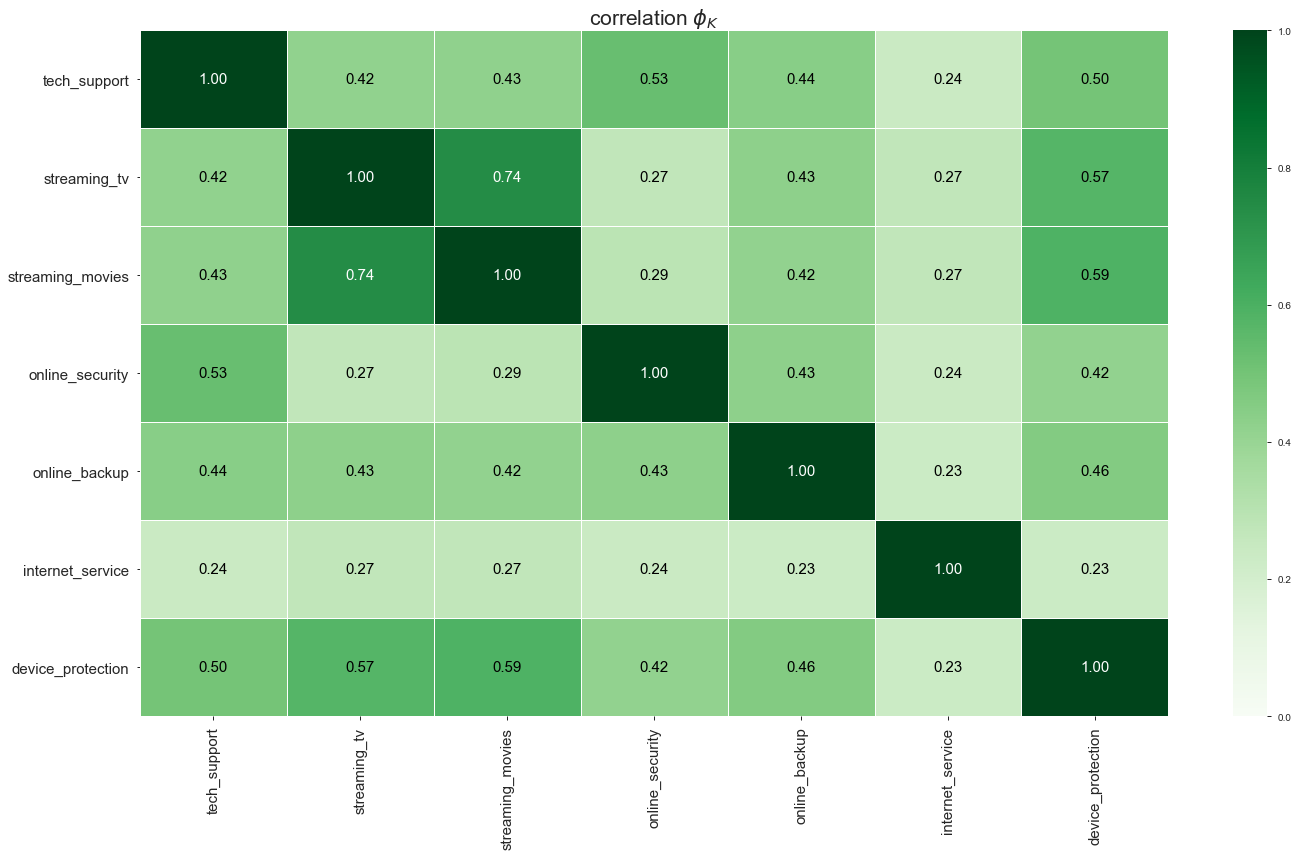

In [86]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                            figsize=(20, 12))
plt.tight_layout()

Видим некоторую зависимость между 'streaming_tv' и 'streaming_movies'. А в остальном все в пределах нормы.

 6. На целевой признак влияет 'internet_service'.

In [87]:
df_cat[(df_cat['churn']==1)].groupby(['internet_service', 'multiple_lines'])['gender'].count()

internet_service  multiple_lines
DSL               No                216
                  Unknown           170
                  Yes                73
Fiber optic       No                530
                  Yes               767
No                No                103
                  Yes                10
Name: gender, dtype: int64

Видим, что больше всего ушло людей, пользующихся и Fiber optic и телефонией - подавляющее большинство. 

Возможно, способ подключения по оптическому каналу появился недавно?

In [88]:
df_cat[df_cat['internet_service']=='Fiber optic']['begin_date'].sort_values()

customerID
2889-FPWRM   2013-10-01
0917-EZOLA   2013-10-01
7317-GGVPB   2013-11-01
2834-JRTUA   2013-11-01
1555-DJEQW   2013-12-01
                ...    
2424-WVHPL   2020-01-01
1640-PLFMP   2020-01-01
2468-SJFLM   2020-01-01
7439-DKZTW   2020-01-01
1452-VOQCH   2020-01-01
Name: begin_date, Length: 3096, dtype: datetime64[ns]

Нет. был давно. Возможно, тарифы изменились?

Посмотрим на клиентов с высоким ежемесячным платежом в группировке по факту ухода.

In [89]:
df_cat[df_cat['monthly_charges']>100].groupby('churn').count()

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,fact_month,m_month
churn,,,,,,,,,,,,,,,,,,,,,
0,649,649,649,649,649,649,649,649,649,649,...,649,649,649,649,649,649,649,649,649,649
1,253,253,253,253,253,253,253,253,253,253,...,253,253,253,253,253,253,253,253,253,253


Видим, что с платежом больше 100 у.е. уходит только 25% клиентов. 

Посмотрим медианный платеж у клиентов, подключившихся до 1 января 2017 года.

In [90]:
df_cat[(df_cat['begin_date'] < '2017-01-01')][['monthly_charges', 'churn']].mean()

monthly_charges    72.308274
churn               0.126053
dtype: float64

Видим, что клиенты почти не уходят. 

Посмотрим медианный платеж у клиентов, подключившихся после 1 января 2017 года.

In [91]:
df_cat[(df_cat['begin_date'] > '2017-01-01')][['monthly_charges', 'churn']].mean()

monthly_charges    59.211597
churn               0.370157
dtype: float64

Видим, что средний платеж стал меньше, но клиенты стали больше уходить!

Посмотрим на те же данные, но при условии подключения по оптическому каналу. 

In [92]:
df_cat[(df_cat['begin_date'] < '2017-01-01')&(df_cat['internet_service']=='Fiber optic')][['monthly_charges', 'churn']].mean()

monthly_charges    99.346191
churn               0.220314
dtype: float64

In [93]:
df_cat[(df_cat['begin_date'] > '2017-01-01')&(df_cat['internet_service']=='Fiber optic')][['monthly_charges', 'churn']].mean()

monthly_charges    85.420747
churn               0.572917
dtype: float64

Видим, что до 2017 года средний платеж был вообще 100 у.е., но клиентов уходит немного. А в последние года средний платеж уменьшился, а уходить стало больше половины клиентов. 

Возможно стоит подумать о качестве оказываемых услуг?

Посмотрим описательные статистики и ящики с усами. Может быть у нас есть выбросы?

Смотреть будем на оригинальном датафрейме - df.

In [94]:
df[df['churn']==1].describe()

,senior_citizen,monthly_charges,total_charges,churn,days
count,1869.000000,1869.000000,1869.000000,1869.0,1869.000000
mean,0.254682,74.441332,1531.796094,1.0,547.352060
std,0.435799,24.666053,1890.822994,0.0,594.389607
min,0.000000,18.850000,18.850000,1.0,30.000000
25%,0.000000,56.150000,134.500000,1.0,61.000000
50%,0.000000,79.650000,703.550000,1.0,304.000000
75%,1.000000,94.200000,2331.300000,1.0,883.000000
max,1.000000,118.350000,8684.800000,1.0,2191.000000


In [95]:
df[df['churn']==0].describe()

,senior_citizen,monthly_charges,total_charges,churn,days
count,5163.000000,5163.000000,5163.000000,5163.0,5163.000000
mean,0.128995,61.307408,2555.344141,0.0,1146.885532
std,0.335227,31.094557,2329.456984,0.0,732.773458
min,0.000000,18.250000,18.800000,0.0,31.000000
25%,0.000000,25.100000,577.825000,0.0,457.000000
50%,0.000000,64.450000,1683.600000,0.0,1157.000000
75%,0.000000,88.475000,4264.125000,0.0,1857.000000
max,1.000000,118.750000,8672.450000,0.0,2191.000000


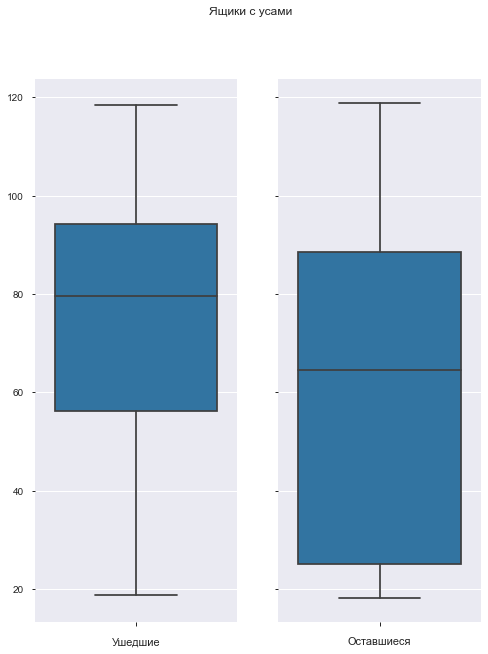

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 10), sharey=True)
sns.boxplot(data=df[df['churn']==1], y='monthly_charges', ax=ax1)
sns.boxplot(data=df[df['churn']==0], y='monthly_charges', ax=ax2)

ax1.set_xlabel('Ушедшие'), ax1.set_ylabel('')
ax2.set_xlabel('Оставшиеся'), ax2.set_ylabel('')
plt.suptitle(
    'Ящики с усами')
plt.show()

Выбросов не обнаружено. Но можно видеть, что среднее значение платежа у ушедших больше. Также можно отметить, что у оставшихся разброс значений платежа большой, в то время, как у ушедщих значения ежемесячного платежа более компактны. 

Построим гистограммы платежей у ушедших и оставшихся клиентов. Для этого напишем отдельную функцию.  

In [97]:
# Построим распределения величин ежемесячных платежей
def phist_1(col, title):
    sns.set_style('whitegrid')
    g = sns.FacetGrid(df, col='churn')
    g.map(sns.histplot, col, bins=20, kde=True, color='blue')
    g.fig.set_figwidth(16)
    g.fig.set_figheight(8)
    g.set_xlabels('Среднемесячные оплаты')
    g.set_ylabels('Количество')
    plt.show()

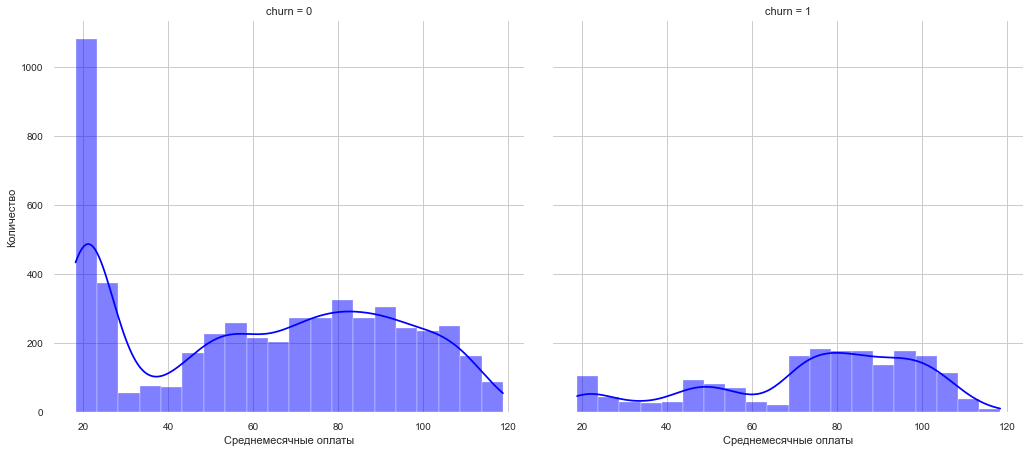

In [98]:
phist_1('monthly_charges', 'Ежемесячный платеж')

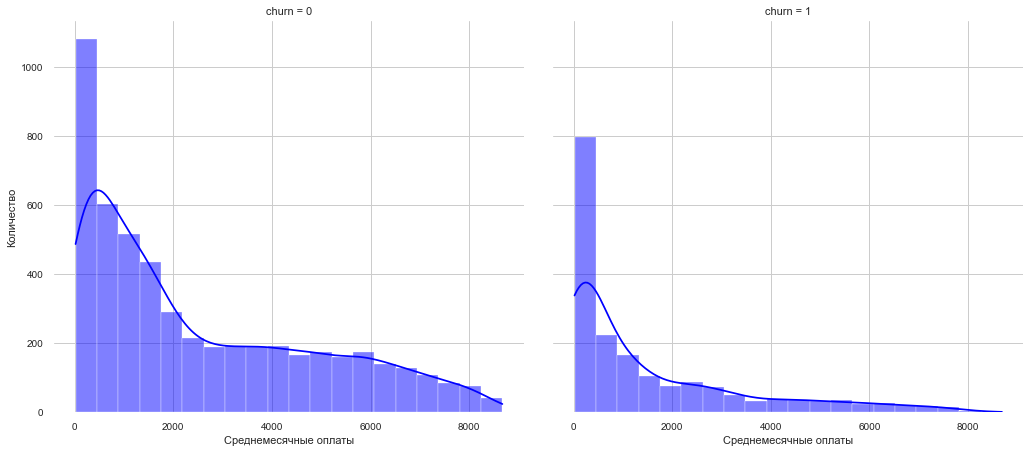

In [99]:
phist_1('total_charges', 'Общий платеж')

В целом, гистограммы подтвердили наши выводы из ящиков с усами. 

Таким образом, не вижу поводов для корректировки df. А df_cat мы использовали для удобства. 

На мой взгляд, конкретные даты начала и конца конктрата не так уж важны. А дату конца точно надо убирать, тк это "слив" информации. Эти стобцы удаляем. Также удалим 'total_charges', так как он коррелирует с ежемесячным платежем. 

In [100]:
df = df.drop(columns = ['end_date','begin_date','total_charges'], axis = 1)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7032 non-null   object 
 1   senior_citizen     7032 non-null   int64  
 2   partner            7032 non-null   object 
 3   dependents         7032 non-null   object 
 4   type               7032 non-null   object 
 5   paperless_billing  7032 non-null   object 
 6   payment_method     7032 non-null   object 
 7   monthly_charges    7032 non-null   float64
 8   churn              7032 non-null   int64  
 9   days               7032 non-null   int64  
 10  internet_service   7032 non-null   object 
 11  online_security    7032 non-null   object 
 12  online_backup      7032 non-null   object 
 13  device_protection  7032 non-null   object 
 14  tech_support       7032 non-null   object 
 15  streaming_tv       7032 non-null   object 
 16  streaming_movi

##### Удаление дубликатов

In [102]:
df = df.drop_duplicates().reset_index(drop = True)

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009 entries, 0 to 7008
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7009 non-null   object 
 1   senior_citizen     7009 non-null   int64  
 2   partner            7009 non-null   object 
 3   dependents         7009 non-null   object 
 4   type               7009 non-null   object 
 5   paperless_billing  7009 non-null   object 
 6   payment_method     7009 non-null   object 
 7   monthly_charges    7009 non-null   float64
 8   churn              7009 non-null   int64  
 9   days               7009 non-null   int64  
 10  internet_service   7009 non-null   object 
 11  online_security    7009 non-null   object 
 12  online_backup      7009 non-null   object 
 13  device_protection  7009 non-null   object 
 14  tech_support       7009 non-null   object 
 15  streaming_tv       7009 non-null   object 
 16  streaming_movies   7009 

### Вывод

Таким образом, исходя из выше проведенного исследовательского анализа данных, для клиента, который уйдет характерны следующие признаки: 

0. Он пришел к пройвайдеру в последние несколько лет.
1. Он пользуется интернетом. 
2. Интернетом он пользуется по оптоволокну.
3. По мимо интернета он также пользуется телефонией с возможностью многоканальных звонков. 
4. Он скорее пенсионер. =)

Благодаря проведенному анализу, мы попытались нарисовать портрет типичного клиента, который уйдет. 

Что касается подготовки данных к последующему обучению моделей, то, согласно плану:
1. столбцы были приведены к змеиному регистру,
2. данные были очищены от пропусков,
3. выбросов в количественных признаках найдено не было,
4. был добавлен столбец days (срок жизни клиента в днях), 
5. было произведено изменение типов данных, в частности дат,
6. просмотр распределения данных был произведен на количественных признаках,
7. столбцы с датами были удалены, так как из-за них происходит утечка данных,
8. дубликаты удалены,
9. в итоге была получена склеиная их четырех исходных таблица, готовая к использованию в дальнейшем машинном обучении,
10. в конце были удалены дубликаты.


## Предобработка данных перед обучением

### Кодирование категориальных признаков

In [104]:
df.head(3)

,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,churn,days,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,0,31,DSL,No,Yes,No,No,No,No,Unknown
1,Male,0,No,No,One year,No,Mailed check,56.95,0,1036,DSL,Yes,No,Yes,No,No,No,No
2,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,1,61,DSL,Yes,Yes,No,No,No,No,No


Так как планируем использовать разные модели для обучения, в том числе и линейные, такие как логистическая регресиия, то нельзя использовать технику OrdinalEncoder. Будеи использовать OHE, убирая первый признак. 

In [105]:
df = pd.get_dummies(df,drop_first=True)
print(df.head())
df.info()

   senior_citizen  monthly_charges  churn  days  gender_Male  partner_Yes  \
0               0            29.85      0    31            0            1   
1               0            56.95      0  1036            1            0   
2               0            53.85      1    61            1            0   
3               0            42.30      0  1371            1            0   
4               0            70.70      1    61            0            0   

   dependents_Yes  type_One year  type_Two year  paperless_billing_Yes  ...  \
0               0              0              0                      1  ...   
1               0              1              0                      0  ...   
2               0              0              0                      1  ...   
3               0              1              0                      0  ...   
4               0              0              0                      1  ...   

   internet_service_Fiber optic  internet_service_No  online_s

### Проверка признаков на взаимную корреляцию

In [106]:
features = df.drop(['churn'], axis=1)
target = df['churn']

Проверим, есть ли корреляция между признаками. Будем смотреть на коэффициент Phik.

In [107]:
df.head(2)

,senior_citizen,monthly_charges,churn,days,gender_Male,partner_Yes,dependents_Yes,type_One year,type_Two year,paperless_billing_Yes,...,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Unknown,multiple_lines_Yes
0,0,29.85,0,31,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,0,56.95,0,1036,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0


In [108]:
interval_cols = ['monthly_charges','days']
phik_overview = features.phik_matrix(interval_cols=interval_cols)

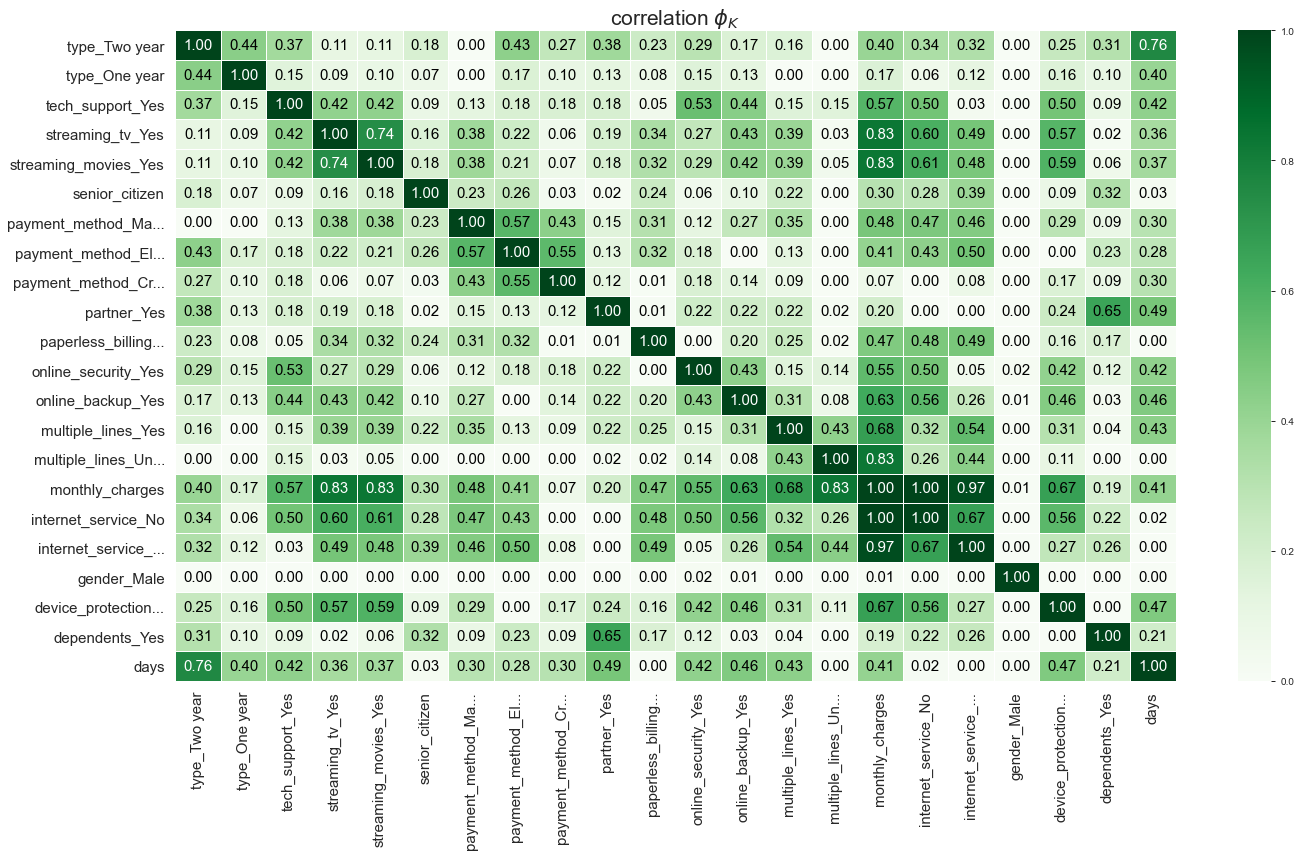

In [109]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                            figsize=(20, 12))
plt.tight_layout()

Удалим столбцы с большой корреляцией. 

In [110]:
features = features.drop(['internet_service_Fiber optic', 'streaming_tv_Yes', 'streaming_movies_Yes', 'multiple_lines_Unknown', 'internet_service_No'], axis=1)
target = df['churn']

In [111]:
interval_cols = ['monthly_charges','days']
phik_overview = features.phik_matrix(interval_cols=interval_cols)

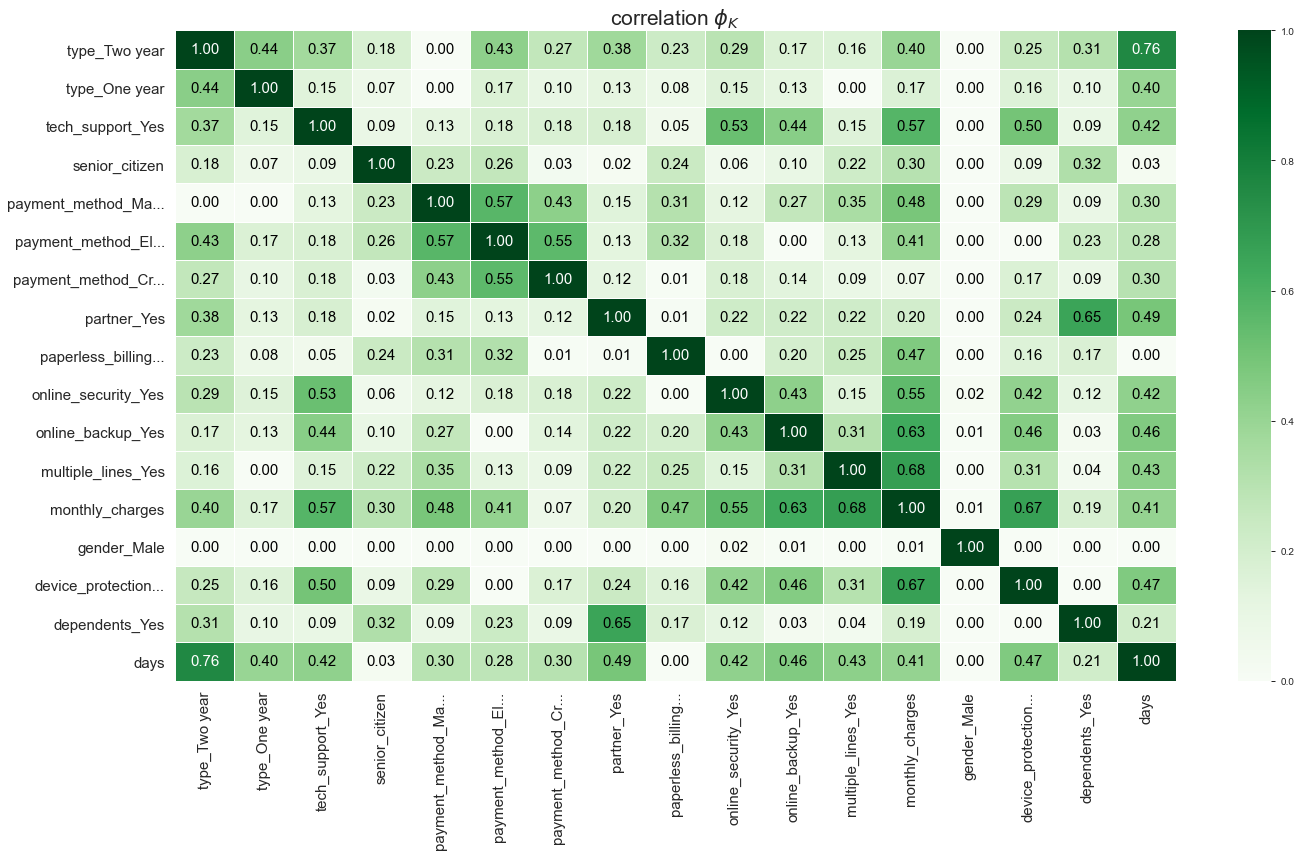

In [112]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 12))
plt.tight_layout()

In [113]:
features = features.drop(['type_Two year'], axis=1)
target = df['churn']

In [114]:
interval_cols = ['monthly_charges', 'days']
phik_overview = features.phik_matrix(interval_cols=interval_cols)

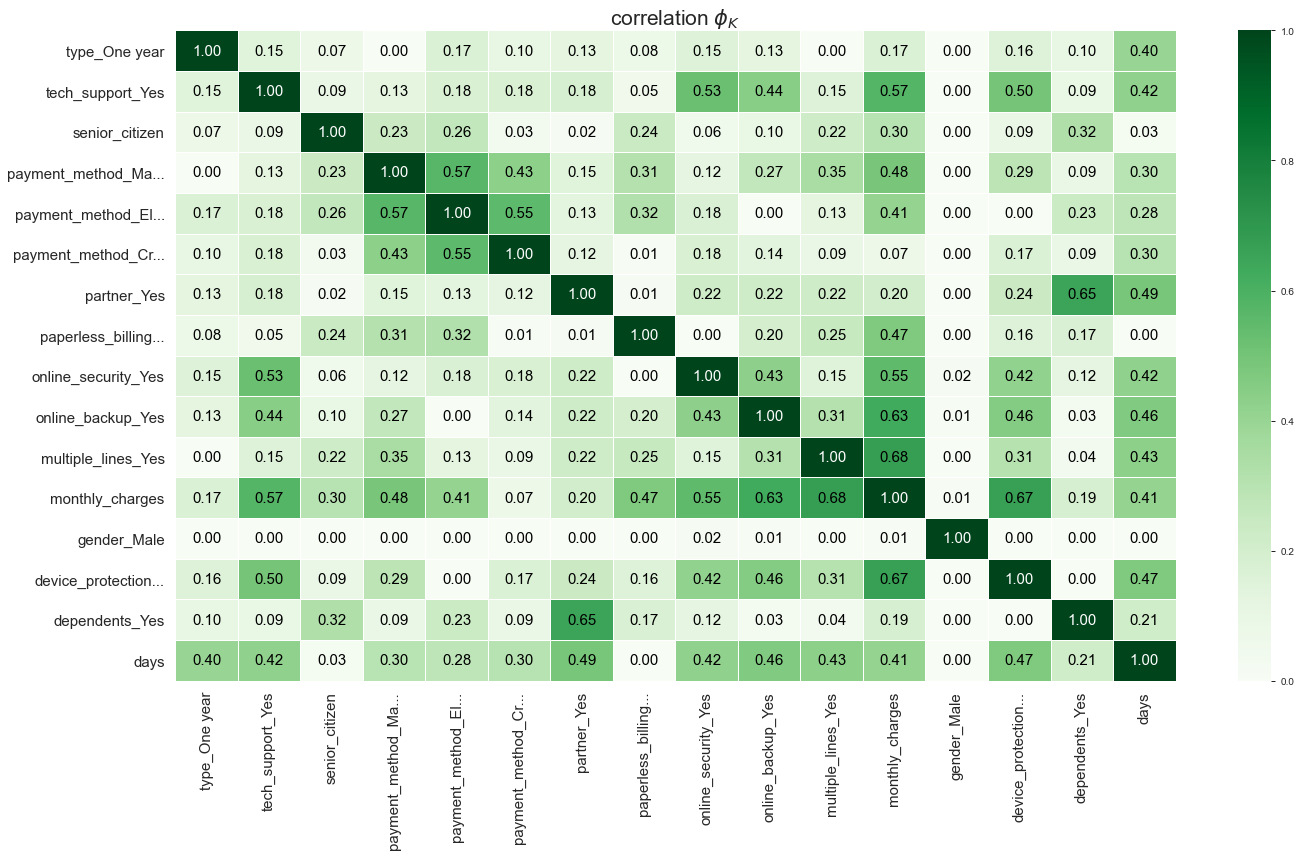

In [115]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 12))
plt.tight_layout()

In [116]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009 entries, 0 to 7008
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   senior_citizen                          7009 non-null   int64  
 1   monthly_charges                         7009 non-null   float64
 2   days                                    7009 non-null   int64  
 3   gender_Male                             7009 non-null   uint8  
 4   partner_Yes                             7009 non-null   uint8  
 5   dependents_Yes                          7009 non-null   uint8  
 6   type_One year                           7009 non-null   uint8  
 7   paperless_billing_Yes                   7009 non-null   uint8  
 8   payment_method_Credit card (automatic)  7009 non-null   uint8  
 9   payment_method_Electronic check         7009 non-null   uint8  
 10  payment_method_Mailed check             7009 non-null   uint

### Разделение на обучающую и тестовую выборки

Разделим выборку на обучающую и тестовую для использования в общей функции в отношении 4:1 (def algorithm_pipeline_3)

In [117]:
features_train, features_test, target_train, target_test = train_test_split(
                                                        features,  target, test_size=0.2, random_state=250722, stratify=target)

Проверим корректность разделения исходных данных на выборки.

In [118]:
features_train.shape, features_test.shape, 

((5607, 16), (1402, 16))

Разделение выполнено корректно. 
Проверим баланс классов.

In [119]:
target_train.mean(), target_test.mean()

(0.2655609060103442, 0.2653352353780314)

Баланс классов равный благодаря параметру stratify. Чего и следовало ожидать. 

### Масштабирование признаков

Произведем масштабирование признаков. Мной были испробованы три варинта: StandardScaler, MinMaxScaler и RobustScaler. Однако по моей субъективной оценке, полученной исключительно эмпирическим путем, наилучший результат все-таки дает старый добрый  StandardScaler. 

In [120]:
numeric = ['monthly_charges', 'days']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.head(10)) 

      senior_citizen  monthly_charges      days  gender_Male  partner_Yes  \
2613               0         0.466521  1.564370            1            1   
5846               0        -0.312023 -0.355689            1            0   
2029               1         0.184319 -1.292270            0            0   
1462               0         0.288900 -0.393206            0            0   
1783               0         0.433321 -0.844748            0            0   
550                0         1.678326  1.601887            0            1   
4293               0        -0.479684 -0.434742            0            0   
3600               1        -0.497944  0.911845            1            0   
3789               0         0.964523  1.154365            1            1   
5526               0         1.090684 -1.210537            0            0   

      dependents_Yes  type_One year  paperless_billing_Yes  \
2613               0              0                      1   
5846               0        

### Вывод 

Данные готовы к дальнейшей работе с ними: 

1. категориальные признаки преобразованы в численные техникой OHE
2. определен целевой признак 'churn',
3. произведено разбиение на обучающую и тестовую выборки в отношении 4:1,
4. выполнено масштабирование признаков
5. построена матрица корреляции с использованием коэффициента Phik.

## Обучение моделей

### Поиск гиперпараметров модели с помощью RandomizedSearchCV

In [121]:
#зафиксируем значение генератора случайных чисел для воспроизводимости
seed = 250722

Создадим общую функцию для подбора гиперпараметров моделей. Функция получает на вход параметры, модель, оценщиков (в нашем случае будем смотреть сразу несколько оценок: 'accuracy', 'f1', 'roc_auc', 'precision', 'recall'. Но главная метрика для нас - ROC-AUC. 
Функция выводит оценку на обучающей выборке. 

In [122]:
# функция подсчета времени
def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    time_in_sec = h * 60 * 60 + m *60 + s
    print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))
    return time_in_sec

In [123]:
def model_test(mdl, param, name_mld):
    
    ''' 
    Функция обучение модели:
    param mdl: получает алгоритм обучения модели;
    param param: параметры для обучения;
    param name_mld: название алгоритма обучения;
    return: отсутствует, данные вносятся в df.
    '''
        
    model = mdl
    rand_research_cv = RandomizedSearchCV(estimator = model, param_distributions = param, cv=5, scoring = 'roc_auc' )
    
    # обучение модели
    start = time.time()
    rand_research_cv.fit(features_train,target_train)
    end = time.time()
    time_work = exec_time(start,end)
    
    # сохраняем лучшую модель в переменную
    best = rand_research_cv.best_estimator_
    
    # проверим работу модели на тестовых данных
    predicted_test = best.predict(features_test)
    probabilities_test = best.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    
    # расчитаем метрики
    r_auc = roc_auc_score(target_test, probabilities_one_test)
    acc = accuracy_score(target_test, predicted_test)
    f1 = f1_score(target_test,predicted_test)
    precision = precision_score(target_test, predicted_test, pos_label= 1)
    recall = recall_score(target_test, predicted_test, pos_label=1)
    
    # добавим данные в датафрейм для дальнейшего сравнения
    #df_scor_train.append(name_mld, r_auc, acc, f1, precision, recall, time_work)
    data = {'name': [name_mld], 
            'params' : [best],
            'roc_auc': [r_auc],
            'accuracy': [acc],
            'f1': [f1],
            'precision' : [precision],
            'recall' : [recall],
            'time': [time_work]
           }
    #print(pd.DataFrame(data))
    
    #df_scor_train.append(pd.DataFrame(data), ignore_index=True)
    
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
    print('\n ROC AUC:', round(r_auc,3))
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show() 
    
    return (pd.DataFrame(data))

Создадим такблицу для записи получившихся метрик. 

In [124]:
df_scores = []
df_scores = pd.DataFrame(data=None,
                          index=None,
                          columns=['name', 'params', 'roc_auc', 'accuracy', 'f1', 'precision', 'recall', 'time'],
                          dtype=None,
                          copy=False)
df_scores

,name,params,roc_auc,accuracy,f1,precision,recall,time


#### RandomForestClassifier

Execution Time: 00:00:13

 ROC AUC: 0.862


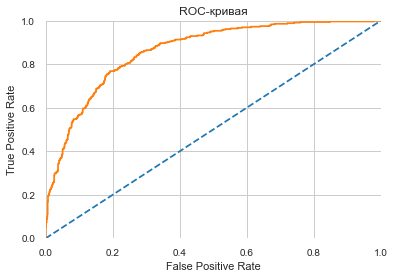

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7464\1823201498.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(v, ignore_index=True)


In [125]:
v = model_test(RandomForestClassifier(random_state=seed, class_weight='balanced'), 
           [{'n_estimators': range(10, 200, 5),
             'max_depth': range(10, 200, 5),
             'max_leaf_nodes': range(10, 200, 5),
             'min_samples_split' : [2,3,4],
             'criterion' : ['gini', 'entropy']}], 'RandomForestClassifier')

df_scores = df_scores.append(v, ignore_index=True)

#### DecisionTreeClassifier

Execution Time: 00:00:01

 ROC AUC: 0.859


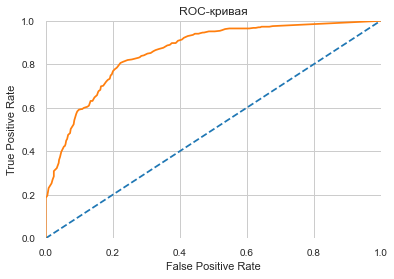

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7464\3006729205.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(v, ignore_index=True)


In [126]:
v = model_test(DecisionTreeClassifier(random_state=seed, class_weight='balanced'), 
           [{
    'max_depth': range(10, 200, 5),
    'min_samples_split' : [int(x) for x in np.linspace(start = 2, stop = 30, num = 15)],
    'min_samples_leaf' : [int(x) for x in np.linspace(start = 1, stop = 30, num = 15)]
           }], 
               'DecisionTreeClassifier')

df_scores = df_scores.append(v, ignore_index=True)

#### LogisticRegression

Execution Time: 00:00:01

 ROC AUC: 0.839


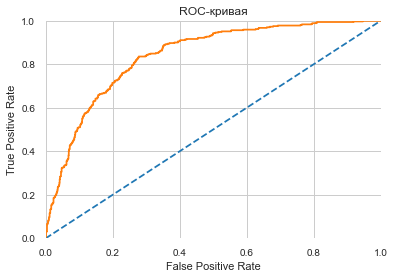

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7464\1622058666.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(v, ignore_index=True)


In [127]:
v = model_test(LogisticRegression(random_state=seed, class_weight='balanced'), 
           [{
    'penalty': ['l1', 'l2'],
    'C' : [0.1, 1.0, 5.0, 10.0],
    'intercept_scaling' : range(5, 100, 5),
    'solver' : ['liblinear', 'saga'],
    'max_iter' : range(5, 100, 5)
           }], 
               'LogisticRegression')

df_scores = df_scores.append(v, ignore_index=True)


#### LGBMClassifier

Execution Time: 00:00:12

 ROC AUC: 0.921


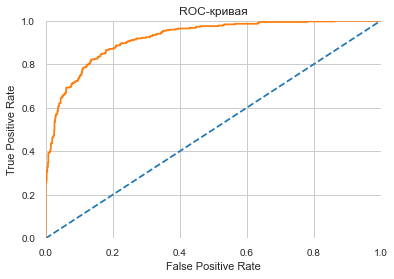

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7464\3376428755.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(v, ignore_index=True)


In [128]:
v = model_test(ltb.LGBMClassifier(random_state=seed, class_weight='balanced'), 
           [{
    'n_estimators': range (100, 200, 50),
    'colsample_bytree': [0.7, 0.8],
    'max_depth': range (10, 100, 20),
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
           }], 
               'LGBMClassifier')

df_scores = df_scores.append(v, ignore_index=True)

#### CatBoostClassifier

0:	learn: 0.6889532	total: 161ms	remaining: 7.88s
1:	learn: 0.6847909	total: 164ms	remaining: 3.94s
2:	learn: 0.6811281	total: 167ms	remaining: 2.61s
3:	learn: 0.6774971	total: 170ms	remaining: 1.95s
4:	learn: 0.6737426	total: 172ms	remaining: 1.55s
5:	learn: 0.6699943	total: 174ms	remaining: 1.27s
6:	learn: 0.6663320	total: 176ms	remaining: 1.08s
7:	learn: 0.6628195	total: 177ms	remaining: 932ms
8:	learn: 0.6593473	total: 179ms	remaining: 817ms
9:	learn: 0.6561426	total: 181ms	remaining: 724ms
10:	learn: 0.6527653	total: 183ms	remaining: 648ms
11:	learn: 0.6494000	total: 184ms	remaining: 584ms
12:	learn: 0.6461727	total: 186ms	remaining: 530ms
13:	learn: 0.6430061	total: 188ms	remaining: 483ms
14:	learn: 0.6399953	total: 190ms	remaining: 442ms
15:	learn: 0.6369591	total: 191ms	remaining: 406ms
16:	learn: 0.6340948	total: 193ms	remaining: 374ms
17:	learn: 0.6311908	total: 195ms	remaining: 346ms
18:	learn: 0.6284288	total: 197ms	remaining: 321ms
19:	learn: 0.6258063	total: 199ms	remaini

20:	learn: 0.6258765	total: 70.1ms	remaining: 96.8ms
21:	learn: 0.6232351	total: 73.2ms	remaining: 93.1ms
22:	learn: 0.6204135	total: 76.3ms	remaining: 89.5ms
23:	learn: 0.6178500	total: 79.2ms	remaining: 85.8ms
24:	learn: 0.6150971	total: 82.8ms	remaining: 82.8ms
25:	learn: 0.6123657	total: 86ms	remaining: 79.4ms
26:	learn: 0.6099821	total: 89.1ms	remaining: 75.9ms
27:	learn: 0.6075083	total: 92.2ms	remaining: 72.5ms
28:	learn: 0.6048973	total: 95.7ms	remaining: 69.3ms
29:	learn: 0.6024917	total: 99.9ms	remaining: 66.6ms
30:	learn: 0.6002483	total: 103ms	remaining: 63.3ms
31:	learn: 0.5977977	total: 106ms	remaining: 59.9ms
32:	learn: 0.5954624	total: 110ms	remaining: 56.8ms
33:	learn: 0.5932523	total: 114ms	remaining: 53.5ms
34:	learn: 0.5910119	total: 117ms	remaining: 50ms
35:	learn: 0.5888406	total: 120ms	remaining: 46.8ms
36:	learn: 0.5865585	total: 124ms	remaining: 43.4ms
37:	learn: 0.5844277	total: 127ms	remaining: 40.1ms
38:	learn: 0.5823884	total: 131ms	remaining: 37ms
39:	lear

16:	learn: 0.5637798	total: 491ms	remaining: 1.53s
17:	learn: 0.5581902	total: 527ms	remaining: 1.52s
18:	learn: 0.5522337	total: 563ms	remaining: 1.51s
19:	learn: 0.5466988	total: 597ms	remaining: 1.49s
20:	learn: 0.5412651	total: 628ms	remaining: 1.47s
21:	learn: 0.5368623	total: 660ms	remaining: 1.44s
22:	learn: 0.5329626	total: 693ms	remaining: 1.42s
23:	learn: 0.5299123	total: 727ms	remaining: 1.39s
24:	learn: 0.5258420	total: 759ms	remaining: 1.36s
25:	learn: 0.5212418	total: 788ms	remaining: 1.33s
26:	learn: 0.5173845	total: 817ms	remaining: 1.3s
27:	learn: 0.5130669	total: 822ms	remaining: 1.23s
28:	learn: 0.5089197	total: 853ms	remaining: 1.21s
29:	learn: 0.5051220	total: 884ms	remaining: 1.18s
30:	learn: 0.5015746	total: 918ms	remaining: 1.16s
31:	learn: 0.4984923	total: 955ms	remaining: 1.13s
32:	learn: 0.4953968	total: 992ms	remaining: 1.11s
33:	learn: 0.4923463	total: 994ms	remaining: 1.05s
34:	learn: 0.4889926	total: 1.03s	remaining: 1.03s
35:	learn: 0.4864152	total: 1.07

43:	learn: 0.4712687	total: 1.6s	remaining: 943ms
44:	learn: 0.4693150	total: 1.64s	remaining: 909ms
45:	learn: 0.4672755	total: 1.68s	remaining: 875ms
46:	learn: 0.4648169	total: 1.74s	remaining: 851ms
47:	learn: 0.4626106	total: 1.81s	remaining: 832ms
48:	learn: 0.4602330	total: 1.95s	remaining: 836ms
49:	learn: 0.4584657	total: 2.02s	remaining: 810ms
50:	learn: 0.4561987	total: 2.04s	remaining: 762ms
51:	learn: 0.4543510	total: 2.05s	remaining: 709ms
52:	learn: 0.4523603	total: 2.05s	remaining: 658ms
53:	learn: 0.4505946	total: 2.11s	remaining: 626ms
54:	learn: 0.4486930	total: 2.17s	remaining: 591ms
55:	learn: 0.4463663	total: 2.22s	remaining: 555ms
56:	learn: 0.4447352	total: 2.27s	remaining: 518ms
57:	learn: 0.4425603	total: 2.32s	remaining: 481ms
58:	learn: 0.4409798	total: 2.37s	remaining: 443ms
59:	learn: 0.4395136	total: 2.43s	remaining: 404ms
60:	learn: 0.4379833	total: 2.47s	remaining: 365ms
61:	learn: 0.4364630	total: 2.53s	remaining: 326ms
62:	learn: 0.4348479	total: 2.58

66:	learn: 0.5645991	total: 57.8s	remaining: 2.59s
67:	learn: 0.5635353	total: 58.7s	remaining: 1.73s
68:	learn: 0.5612791	total: 58.7s	remaining: 851ms
69:	learn: 0.5598068	total: 59.6s	remaining: 0us
0:	learn: 0.6901599	total: 754ms	remaining: 52s
1:	learn: 0.6875663	total: 2.04s	remaining: 1m 9s
2:	learn: 0.6849727	total: 3.08s	remaining: 1m 8s
3:	learn: 0.6830485	total: 4s	remaining: 1m 5s
4:	learn: 0.6807177	total: 4.67s	remaining: 1m
5:	learn: 0.6774570	total: 5.04s	remaining: 53.8s
6:	learn: 0.6746366	total: 5.23s	remaining: 47.1s
7:	learn: 0.6724486	total: 6.04s	remaining: 46.8s
8:	learn: 0.6691262	total: 6.77s	remaining: 45.9s
9:	learn: 0.6656874	total: 6.78s	remaining: 40.7s
10:	learn: 0.6635115	total: 7.41s	remaining: 39.7s
11:	learn: 0.6608702	total: 8.13s	remaining: 39.3s
12:	learn: 0.6586319	total: 8.72s	remaining: 38.3s
13:	learn: 0.6564920	total: 9.35s	remaining: 37.4s
14:	learn: 0.6539237	total: 9.95s	remaining: 36.5s
15:	learn: 0.6514614	total: 10.1s	remaining: 34.1s


19:	learn: 0.6472824	total: 11.6s	remaining: 28.9s
20:	learn: 0.6446485	total: 11.6s	remaining: 27s
21:	learn: 0.6425329	total: 12.3s	remaining: 26.8s
22:	learn: 0.6405445	total: 12.9s	remaining: 26.4s
23:	learn: 0.6386513	total: 13.5s	remaining: 25.9s
24:	learn: 0.6371674	total: 14.3s	remaining: 25.7s
25:	learn: 0.6356509	total: 15s	remaining: 25.4s
26:	learn: 0.6339659	total: 15.7s	remaining: 25s
27:	learn: 0.6321394	total: 16.3s	remaining: 24.4s
28:	learn: 0.6290309	total: 16.3s	remaining: 23.1s
29:	learn: 0.6263454	total: 16.3s	remaining: 21.8s
30:	learn: 0.6244610	total: 17s	remaining: 21.4s
31:	learn: 0.6224390	total: 17.7s	remaining: 21.1s
32:	learn: 0.6208776	total: 18.4s	remaining: 20.6s
33:	learn: 0.6181610	total: 18.4s	remaining: 19.5s
34:	learn: 0.6165490	total: 19s	remaining: 19s
35:	learn: 0.6151101	total: 19.9s	remaining: 18.8s
36:	learn: 0.6131288	total: 21.5s	remaining: 19.1s
37:	learn: 0.6105585	total: 21.6s	remaining: 18.2s
38:	learn: 0.6088544	total: 23.9s	remaining

41:	learn: 0.6013928	total: 37.9s	remaining: 43.3s
42:	learn: 0.5994527	total: 39.2s	remaining: 42.9s
43:	learn: 0.5980113	total: 40.3s	remaining: 42.2s
44:	learn: 0.5964230	total: 41.6s	remaining: 41.6s
45:	learn: 0.5953571	total: 43s	remaining: 41.1s
46:	learn: 0.5940916	total: 44.5s	remaining: 40.7s
47:	learn: 0.5924307	total: 45.6s	remaining: 39.9s
48:	learn: 0.5905590	total: 46.5s	remaining: 38.9s
49:	learn: 0.5891303	total: 47.3s	remaining: 37.8s
50:	learn: 0.5876836	total: 48.6s	remaining: 37.2s
51:	learn: 0.5852294	total: 48.7s	remaining: 35.6s
52:	learn: 0.5840542	total: 49.8s	remaining: 34.8s
53:	learn: 0.5827233	total: 50.9s	remaining: 33.9s
54:	learn: 0.5811176	total: 51.9s	remaining: 33s
55:	learn: 0.5797748	total: 52.8s	remaining: 32s
56:	learn: 0.5786740	total: 53.5s	remaining: 31s
57:	learn: 0.5774405	total: 54.1s	remaining: 29.9s
58:	learn: 0.5762022	total: 54.9s	remaining: 28.8s
59:	learn: 0.5750415	total: 55.7s	remaining: 27.9s
60:	learn: 0.5729880	total: 55.8s	remai

24:	learn: 0.6306594	total: 12.8s	remaining: 33.3s
25:	learn: 0.6287062	total: 14s	remaining: 34.4s
26:	learn: 0.6270245	total: 14.9s	remaining: 34.8s
27:	learn: 0.6253477	total: 15.7s	remaining: 34.8s
28:	learn: 0.6237783	total: 16.4s	remaining: 34.6s
29:	learn: 0.6217127	total: 17.1s	remaining: 34.2s
30:	learn: 0.6199813	total: 17.7s	remaining: 33.7s
31:	learn: 0.6185782	total: 18.4s	remaining: 33.3s
32:	learn: 0.6167729	total: 19s	remaining: 32.8s
33:	learn: 0.6151519	total: 19.6s	remaining: 32.3s
34:	learn: 0.6138665	total: 20.3s	remaining: 31.9s
35:	learn: 0.6121011	total: 21.5s	remaining: 32.2s
36:	learn: 0.6105144	total: 22.6s	remaining: 32.4s
37:	learn: 0.6089566	total: 23.8s	remaining: 32.6s
38:	learn: 0.6073854	total: 25.6s	remaining: 33.5s
39:	learn: 0.6055377	total: 27.3s	remaining: 34.1s
40:	learn: 0.6045270	total: 28.8s	remaining: 34.4s
41:	learn: 0.6019241	total: 28.8s	remaining: 32.9s
42:	learn: 0.6002793	total: 30s	remaining: 32.8s
43:	learn: 0.5982037	total: 31.3s	rem

6:	learn: 0.6733385	total: 3.65s	remaining: 43.3s
7:	learn: 0.6704512	total: 4.54s	remaining: 46.6s
8:	learn: 0.6677888	total: 5.68s	remaining: 51.1s
9:	learn: 0.6659523	total: 7.11s	remaining: 56.9s
10:	learn: 0.6624991	total: 7.12s	remaining: 51.2s
11:	learn: 0.6598197	total: 8.01s	remaining: 52s
12:	learn: 0.6570685	total: 8.9s	remaining: 52.7s
13:	learn: 0.6553226	total: 10.2s	remaining: 55.3s
14:	learn: 0.6534419	total: 11.4s	remaining: 57.1s
15:	learn: 0.6515765	total: 12.3s	remaining: 56.8s
16:	learn: 0.6500495	total: 13s	remaining: 55.9s
17:	learn: 0.6482084	total: 13.8s	remaining: 55.1s
18:	learn: 0.6452152	total: 13.8s	remaining: 51.6s
19:	learn: 0.6420593	total: 13.8s	remaining: 48.4s
20:	learn: 0.6398247	total: 14.4s	remaining: 47.4s
21:	learn: 0.6379266	total: 14.7s	remaining: 45.6s
22:	learn: 0.6350754	total: 14.8s	remaining: 43.2s
23:	learn: 0.6334005	total: 15.4s	remaining: 42.5s
24:	learn: 0.6318862	total: 16.3s	remaining: 42.3s
25:	learn: 0.6291000	total: 17.2s	remain

78:	learn: 0.5466579	total: 1m 16s	remaining: 30.1s
79:	learn: 0.5455468	total: 1m 18s	remaining: 29.3s
80:	learn: 0.5446743	total: 1m 18s	remaining: 28.3s
81:	learn: 0.5434142	total: 1m 19s	remaining: 27.3s
82:	learn: 0.5421761	total: 1m 21s	remaining: 26.4s
83:	learn: 0.5407155	total: 1m 22s	remaining: 25.4s
84:	learn: 0.5396285	total: 1m 22s	remaining: 24.4s
85:	learn: 0.5387617	total: 1m 24s	remaining: 23.5s
86:	learn: 0.5372199	total: 1m 24s	remaining: 22.4s
87:	learn: 0.5362701	total: 1m 26s	remaining: 21.5s
88:	learn: 0.5345451	total: 1m 26s	remaining: 20.3s
89:	learn: 0.5335793	total: 1m 28s	remaining: 19.6s
90:	learn: 0.5324374	total: 1m 29s	remaining: 18.7s
91:	learn: 0.5312580	total: 1m 30s	remaining: 17.7s
92:	learn: 0.5300500	total: 1m 31s	remaining: 16.7s
93:	learn: 0.5290129	total: 1m 32s	remaining: 15.7s
94:	learn: 0.5276562	total: 1m 33s	remaining: 14.8s
95:	learn: 0.5265201	total: 1m 35s	remaining: 13.9s
96:	learn: 0.5255867	total: 1m 36s	remaining: 13s
97:	learn: 0.5

19:	learn: 0.6434855	total: 19.4s	remaining: 1m 27s
20:	learn: 0.6411521	total: 20.7s	remaining: 1m 27s
21:	learn: 0.6381392	total: 20.7s	remaining: 1m 22s
22:	learn: 0.6351415	total: 20.9s	remaining: 1m 19s
23:	learn: 0.6320861	total: 20.9s	remaining: 1m 15s
24:	learn: 0.6306594	total: 22.8s	remaining: 1m 17s
25:	learn: 0.6287062	total: 24.3s	remaining: 1m 18s
26:	learn: 0.6270245	total: 25.5s	remaining: 1m 18s
27:	learn: 0.6253477	total: 26.7s	remaining: 1m 18s
28:	learn: 0.6237783	total: 27.6s	remaining: 1m 17s
29:	learn: 0.6217127	total: 28.6s	remaining: 1m 16s
30:	learn: 0.6199813	total: 29.6s	remaining: 1m 15s
31:	learn: 0.6185782	total: 30.6s	remaining: 1m 14s
32:	learn: 0.6167729	total: 31.7s	remaining: 1m 13s
33:	learn: 0.6151519	total: 32.7s	remaining: 1m 13s
34:	learn: 0.6138665	total: 33.5s	remaining: 1m 11s
35:	learn: 0.6121011	total: 34.6s	remaining: 1m 11s
36:	learn: 0.6105144	total: 35.7s	remaining: 1m 10s
37:	learn: 0.6089566	total: 36.8s	remaining: 1m 9s
38:	learn: 0.

69:	learn: 0.5622433	total: 1m 11s	remaining: 41.1s
70:	learn: 0.5602038	total: 1m 11s	remaining: 39.5s
71:	learn: 0.5591560	total: 1m 13s	remaining: 38.7s
72:	learn: 0.5576889	total: 1m 14s	remaining: 37.9s
73:	learn: 0.5563301	total: 1m 16s	remaining: 37.1s
74:	learn: 0.5544971	total: 1m 16s	remaining: 35.6s
75:	learn: 0.5536028	total: 1m 18s	remaining: 35.1s
76:	learn: 0.5525139	total: 1m 20s	remaining: 34.5s
77:	learn: 0.5514189	total: 1m 22s	remaining: 33.9s
78:	learn: 0.5502680	total: 1m 24s	remaining: 33.1s
79:	learn: 0.5493063	total: 1m 26s	remaining: 32.3s
80:	learn: 0.5475381	total: 1m 26s	remaining: 30.8s
81:	learn: 0.5463721	total: 1m 27s	remaining: 29.8s
82:	learn: 0.5452598	total: 1m 28s	remaining: 28.7s
83:	learn: 0.5434195	total: 1m 28s	remaining: 27.3s
84:	learn: 0.5425322	total: 1m 29s	remaining: 26.4s
85:	learn: 0.5410682	total: 1m 31s	remaining: 25.6s
86:	learn: 0.5400680	total: 1m 33s	remaining: 24.7s
87:	learn: 0.5388944	total: 1m 35s	remaining: 23.8s
88:	learn: 0

13:	learn: 0.6478888	total: 514ms	remaining: 2.05s
14:	learn: 0.6452400	total: 577ms	remaining: 2.12s
15:	learn: 0.6426763	total: 646ms	remaining: 2.18s
16:	learn: 0.6399216	total: 719ms	remaining: 2.24s
17:	learn: 0.6371303	total: 824ms	remaining: 2.38s
18:	learn: 0.6341885	total: 939ms	remaining: 2.52s
19:	learn: 0.6317060	total: 1.03s	remaining: 2.57s
20:	learn: 0.6293982	total: 1.13s	remaining: 2.63s
21:	learn: 0.6266906	total: 1.15s	remaining: 2.51s
22:	learn: 0.6240545	total: 1.26s	remaining: 2.57s
23:	learn: 0.6211007	total: 1.35s	remaining: 2.59s
24:	learn: 0.6186926	total: 1.44s	remaining: 2.6s
25:	learn: 0.6158817	total: 1.46s	remaining: 2.47s
26:	learn: 0.6135447	total: 1.55s	remaining: 2.47s
27:	learn: 0.6111362	total: 1.63s	remaining: 2.44s
28:	learn: 0.6086168	total: 1.64s	remaining: 2.32s
29:	learn: 0.6059703	total: 1.66s	remaining: 2.21s
30:	learn: 0.6040545	total: 1.73s	remaining: 2.18s
31:	learn: 0.6017786	total: 1.81s	remaining: 2.15s
32:	learn: 0.5995688	total: 1.87

38:	learn: 0.5894288	total: 3.86s	remaining: 3.07s
39:	learn: 0.5876045	total: 4.03s	remaining: 3.02s
40:	learn: 0.5856917	total: 4.17s	remaining: 2.95s
41:	learn: 0.5834582	total: 4.28s	remaining: 2.85s
42:	learn: 0.5813958	total: 4.39s	remaining: 2.75s
43:	learn: 0.5794147	total: 4.49s	remaining: 2.65s
44:	learn: 0.5776231	total: 4.61s	remaining: 2.56s
45:	learn: 0.5755463	total: 4.72s	remaining: 2.46s
46:	learn: 0.5733355	total: 4.81s	remaining: 2.35s
47:	learn: 0.5713654	total: 4.92s	remaining: 2.26s
48:	learn: 0.5694255	total: 5.03s	remaining: 2.16s
49:	learn: 0.5674473	total: 5.13s	remaining: 2.05s
50:	learn: 0.5656493	total: 5.24s	remaining: 1.95s
51:	learn: 0.5638638	total: 5.34s	remaining: 1.85s
52:	learn: 0.5621974	total: 5.45s	remaining: 1.75s
53:	learn: 0.5607308	total: 5.54s	remaining: 1.64s
54:	learn: 0.5591670	total: 5.63s	remaining: 1.53s
55:	learn: 0.5575421	total: 5.71s	remaining: 1.43s
56:	learn: 0.5555798	total: 5.8s	remaining: 1.32s
57:	learn: 0.5538752	total: 5.88

61:	learn: 0.5466778	total: 5.91s	remaining: 762ms
62:	learn: 0.5449663	total: 6.03s	remaining: 670ms
63:	learn: 0.5435353	total: 6.13s	remaining: 575ms
64:	learn: 0.5421953	total: 6.24s	remaining: 480ms
65:	learn: 0.5403764	total: 6.25s	remaining: 379ms
66:	learn: 0.5386446	total: 6.27s	remaining: 281ms
67:	learn: 0.5375583	total: 6.37s	remaining: 187ms
68:	learn: 0.5363154	total: 6.49s	remaining: 94ms
69:	learn: 0.5348672	total: 6.6s	remaining: 0us
0:	learn: 0.6899640	total: 1.33s	remaining: 1m 5s
1:	learn: 0.6875204	total: 2.68s	remaining: 1m 4s
2:	learn: 0.6848528	total: 3.85s	remaining: 1m
3:	learn: 0.6829603	total: 4.79s	remaining: 55.1s
4:	learn: 0.6806023	total: 5.66s	remaining: 50.9s
5:	learn: 0.6774752	total: 6.65s	remaining: 48.8s
6:	learn: 0.6755429	total: 7.64s	remaining: 46.9s
7:	learn: 0.6736237	total: 8.94s	remaining: 47s
8:	learn: 0.6719343	total: 10.2s	remaining: 46.5s
9:	learn: 0.6700964	total: 11.6s	remaining: 46.4s
10:	learn: 0.6679786	total: 13s	remaining: 46.2s
1

6:	learn: 0.6738879	total: 4s	remaining: 24.6s
7:	learn: 0.6713139	total: 4.67s	remaining: 24.5s
8:	learn: 0.6685108	total: 5.42s	remaining: 24.7s
9:	learn: 0.6668010	total: 6.15s	remaining: 24.6s
10:	learn: 0.6652192	total: 6.85s	remaining: 24.3s
11:	learn: 0.6631254	total: 7.75s	remaining: 24.5s
12:	learn: 0.6609142	total: 8.71s	remaining: 24.8s
13:	learn: 0.6587652	total: 9.64s	remaining: 24.8s
14:	learn: 0.6567052	total: 11.5s	remaining: 26.8s
15:	learn: 0.6549191	total: 13.2s	remaining: 28s
16:	learn: 0.6524176	total: 13.3s	remaining: 25.8s
17:	learn: 0.6506744	total: 14.7s	remaining: 26.1s
18:	learn: 0.6492560	total: 15.8s	remaining: 25.8s
19:	learn: 0.6472824	total: 17s	remaining: 25.5s
20:	learn: 0.6446485	total: 17.1s	remaining: 23.6s
21:	learn: 0.6425329	total: 18.2s	remaining: 23.2s
22:	learn: 0.6405445	total: 19.8s	remaining: 23.2s
23:	learn: 0.6386513	total: 21.2s	remaining: 22.9s
24:	learn: 0.6371674	total: 22.5s	remaining: 22.5s
25:	learn: 0.6356509	total: 23.8s	remainin

71:	learn: 0.4118431	total: 5.83s	remaining: 1.46s
72:	learn: 0.4105168	total: 5.88s	remaining: 1.37s
73:	learn: 0.4092153	total: 5.93s	remaining: 1.28s
74:	learn: 0.4078456	total: 5.99s	remaining: 1.2s
75:	learn: 0.4066947	total: 6.04s	remaining: 1.11s
76:	learn: 0.4053915	total: 6.09s	remaining: 1.03s
77:	learn: 0.4044251	total: 6.14s	remaining: 945ms
78:	learn: 0.4032224	total: 6.19s	remaining: 862ms
79:	learn: 0.4020763	total: 6.24s	remaining: 780ms
80:	learn: 0.4010523	total: 6.29s	remaining: 699ms
81:	learn: 0.3997768	total: 6.34s	remaining: 618ms
82:	learn: 0.3985580	total: 6.38s	remaining: 538ms
83:	learn: 0.3975197	total: 6.43s	remaining: 459ms
84:	learn: 0.3962989	total: 6.47s	remaining: 381ms
85:	learn: 0.3953255	total: 6.51s	remaining: 303ms
86:	learn: 0.3943141	total: 6.56s	remaining: 226ms
87:	learn: 0.3932192	total: 6.6s	remaining: 150ms
88:	learn: 0.3922499	total: 6.64s	remaining: 74.6ms
89:	learn: 0.3912762	total: 6.68s	remaining: 0us
0:	learn: 0.6831879	total: 40.3ms	

53:	learn: 0.4435236	total: 3.63s	remaining: 2.42s
54:	learn: 0.4414843	total: 3.64s	remaining: 2.32s
55:	learn: 0.4398092	total: 3.7s	remaining: 2.25s
56:	learn: 0.4378570	total: 3.73s	remaining: 2.16s
57:	learn: 0.4359351	total: 3.82s	remaining: 2.11s
58:	learn: 0.4342581	total: 3.92s	remaining: 2.06s
59:	learn: 0.4324822	total: 4.02s	remaining: 2.01s
60:	learn: 0.4309675	total: 4.11s	remaining: 1.95s
61:	learn: 0.4295146	total: 4.19s	remaining: 1.89s
62:	learn: 0.4280958	total: 4.28s	remaining: 1.83s
63:	learn: 0.4265000	total: 4.37s	remaining: 1.77s
64:	learn: 0.4251752	total: 4.45s	remaining: 1.71s
65:	learn: 0.4237640	total: 4.53s	remaining: 1.65s
66:	learn: 0.4221065	total: 4.61s	remaining: 1.58s
67:	learn: 0.4208649	total: 4.69s	remaining: 1.52s
68:	learn: 0.4195555	total: 4.77s	remaining: 1.45s
69:	learn: 0.4179802	total: 4.84s	remaining: 1.38s
70:	learn: 0.4166035	total: 4.87s	remaining: 1.3s
71:	learn: 0.4152269	total: 4.96s	remaining: 1.24s
72:	learn: 0.4141578	total: 5.04s

35:	learn: 0.4886221	total: 2.94s	remaining: 4.42s
36:	learn: 0.4858441	total: 3.04s	remaining: 4.35s
37:	learn: 0.4832298	total: 3.13s	remaining: 4.29s
38:	learn: 0.4810151	total: 3.23s	remaining: 4.22s
39:	learn: 0.4777348	total: 3.24s	remaining: 4.05s
40:	learn: 0.4748508	total: 3.34s	remaining: 3.99s
41:	learn: 0.4726464	total: 3.44s	remaining: 3.93s
42:	learn: 0.4700203	total: 3.53s	remaining: 3.86s
43:	learn: 0.4674700	total: 3.62s	remaining: 3.79s
44:	learn: 0.4653680	total: 3.72s	remaining: 3.72s
45:	learn: 0.4633272	total: 3.81s	remaining: 3.64s
46:	learn: 0.4610372	total: 3.89s	remaining: 3.56s
47:	learn: 0.4585797	total: 3.98s	remaining: 3.48s
48:	learn: 0.4563056	total: 4.06s	remaining: 3.39s
49:	learn: 0.4545207	total: 4.11s	remaining: 3.29s
50:	learn: 0.4522552	total: 4.14s	remaining: 3.17s
51:	learn: 0.4501938	total: 4.22s	remaining: 3.09s
52:	learn: 0.4481814	total: 4.33s	remaining: 3.02s
53:	learn: 0.4460599	total: 4.45s	remaining: 2.97s
54:	learn: 0.4442477	total: 4.5

23:	learn: 0.5229925	total: 183ms	remaining: 198ms
24:	learn: 0.5186383	total: 191ms	remaining: 191ms
25:	learn: 0.5144161	total: 198ms	remaining: 183ms
26:	learn: 0.5109624	total: 205ms	remaining: 175ms
27:	learn: 0.5075612	total: 212ms	remaining: 166ms
28:	learn: 0.5039341	total: 218ms	remaining: 158ms
29:	learn: 0.5003447	total: 225ms	remaining: 150ms
30:	learn: 0.4973763	total: 232ms	remaining: 142ms
31:	learn: 0.4939736	total: 238ms	remaining: 134ms
32:	learn: 0.4911245	total: 244ms	remaining: 126ms
33:	learn: 0.4884787	total: 252ms	remaining: 118ms
34:	learn: 0.4855147	total: 259ms	remaining: 111ms
35:	learn: 0.4828158	total: 265ms	remaining: 103ms
36:	learn: 0.4804399	total: 271ms	remaining: 95.4ms
37:	learn: 0.4779168	total: 278ms	remaining: 87.7ms
38:	learn: 0.4752774	total: 284ms	remaining: 80.1ms
39:	learn: 0.4727248	total: 291ms	remaining: 72.6ms
40:	learn: 0.4707202	total: 296ms	remaining: 65.1ms
41:	learn: 0.4684469	total: 303ms	remaining: 57.8ms
42:	learn: 0.4661669	tota

34:	learn: 0.5112493	total: 37.5s	remaining: 58.9s
35:	learn: 0.5085649	total: 38.8s	remaining: 58.3s
36:	learn: 0.5057055	total: 40.2s	remaining: 57.5s
37:	learn: 0.5035842	total: 41.7s	remaining: 57s
38:	learn: 0.5011546	total: 43.2s	remaining: 56.5s
39:	learn: 0.4979553	total: 44.7s	remaining: 55.9s
40:	learn: 0.4949138	total: 46.2s	remaining: 55.2s
41:	learn: 0.4920991	total: 47.6s	remaining: 54.4s
42:	learn: 0.4896585	total: 49s	remaining: 53.6s
43:	learn: 0.4871800	total: 50.3s	remaining: 52.6s
44:	learn: 0.4851445	total: 51.6s	remaining: 51.6s
45:	learn: 0.4826758	total: 52.9s	remaining: 50.6s
46:	learn: 0.4807767	total: 54.2s	remaining: 49.6s
47:	learn: 0.4766612	total: 54.2s	remaining: 47.5s
48:	learn: 0.4729384	total: 54.3s	remaining: 45.4s
49:	learn: 0.4712409	total: 55.5s	remaining: 44.4s
50:	learn: 0.4673381	total: 55.5s	remaining: 42.5s
51:	learn: 0.4652922	total: 56.5s	remaining: 41.3s
52:	learn: 0.4626806	total: 57.5s	remaining: 40.2s
53:	learn: 0.4599804	total: 58.5s	r

16:	learn: 0.5763758	total: 3.38s	remaining: 15.4s
17:	learn: 0.5726416	total: 3.65s	remaining: 15.5s
18:	learn: 0.5682806	total: 3.93s	remaining: 15.5s
19:	learn: 0.5649260	total: 4.2s	remaining: 15.5s
20:	learn: 0.5601148	total: 4.48s	remaining: 15.4s
21:	learn: 0.5556484	total: 4.75s	remaining: 15.4s
22:	learn: 0.5516368	total: 5.02s	remaining: 15.3s
23:	learn: 0.5484294	total: 5.29s	remaining: 15.2s
24:	learn: 0.5457227	total: 5.59s	remaining: 15.1s
25:	learn: 0.5403395	total: 5.59s	remaining: 14.3s
26:	learn: 0.5374971	total: 5.88s	remaining: 14.3s
27:	learn: 0.5338294	total: 6.17s	remaining: 14.2s
28:	learn: 0.5312546	total: 6.48s	remaining: 14.1s
29:	learn: 0.5266059	total: 6.49s	remaining: 13.4s
30:	learn: 0.5240080	total: 6.81s	remaining: 13.4s
31:	learn: 0.5192526	total: 7.09s	remaining: 13.3s
32:	learn: 0.5143325	total: 7.1s	remaining: 12.6s
33:	learn: 0.5096240	total: 7.1s	remaining: 12.1s
34:	learn: 0.5070565	total: 7.39s	remaining: 12s
35:	learn: 0.5047335	total: 7.7s	rem

88:	learn: 0.4131619	total: 27.6s	remaining: 310ms
89:	learn: 0.4112627	total: 28s	remaining: 0us
0:	learn: 0.6840786	total: 362ms	remaining: 32.2s
1:	learn: 0.6774497	total: 734ms	remaining: 32.3s
2:	learn: 0.6710432	total: 1.16s	remaining: 33.6s
3:	learn: 0.6640838	total: 1.6s	remaining: 34.5s
4:	learn: 0.6540014	total: 1.61s	remaining: 27.3s
5:	learn: 0.6438631	total: 1.61s	remaining: 22.6s
6:	learn: 0.6375964	total: 2.03s	remaining: 24s
7:	learn: 0.6302700	total: 2.47s	remaining: 25.3s
8:	learn: 0.6253642	total: 2.87s	remaining: 25.8s
9:	learn: 0.6207891	total: 3.29s	remaining: 26.3s
10:	learn: 0.6118708	total: 3.29s	remaining: 23.6s
11:	learn: 0.6038796	total: 3.3s	remaining: 21.4s
12:	learn: 0.5996800	total: 3.69s	remaining: 21.9s
13:	learn: 0.5952988	total: 4.06s	remaining: 22s
14:	learn: 0.5907236	total: 4.43s	remaining: 22.1s
15:	learn: 0.5853622	total: 4.76s	remaining: 22s
16:	learn: 0.5811542	total: 5.16s	remaining: 22.1s
17:	learn: 0.5777392	total: 5.56s	remaining: 22.2s
18

70:	learn: 0.4161455	total: 1.96s	remaining: 524ms
71:	learn: 0.4148164	total: 1.99s	remaining: 497ms
72:	learn: 0.4137227	total: 1.99s	remaining: 463ms
73:	learn: 0.4124872	total: 2.02s	remaining: 437ms
74:	learn: 0.4112350	total: 2.05s	remaining: 409ms
75:	learn: 0.4098558	total: 2.06s	remaining: 380ms
76:	learn: 0.4088731	total: 2.1s	remaining: 354ms
77:	learn: 0.4076434	total: 2.1s	remaining: 324ms
78:	learn: 0.4064638	total: 2.13s	remaining: 297ms
79:	learn: 0.4053190	total: 2.16s	remaining: 270ms
80:	learn: 0.4041677	total: 2.19s	remaining: 243ms
81:	learn: 0.4031598	total: 2.19s	remaining: 214ms
82:	learn: 0.4020345	total: 2.23s	remaining: 188ms
83:	learn: 0.4009655	total: 2.26s	remaining: 161ms
84:	learn: 0.3998951	total: 2.29s	remaining: 135ms
85:	learn: 0.3990262	total: 2.31s	remaining: 108ms
86:	learn: 0.3981064	total: 2.34s	remaining: 80.8ms
87:	learn: 0.3972183	total: 2.37s	remaining: 53.9ms
88:	learn: 0.3963810	total: 2.4s	remaining: 27ms
89:	learn: 0.3953703	total: 2.43s

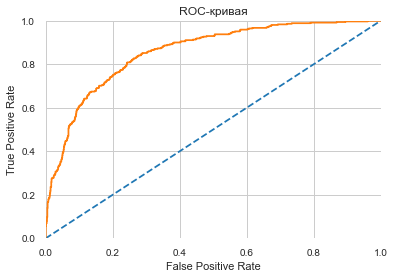

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7464\2421804988.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(v, ignore_index=True)


In [129]:
v = model_test(ctb.CatBoostClassifier(random_state=seed),
           [{
    'depth' : [5, 8, 11, 15],
    'learning_rate' : [0.01, 0.03],
    'iterations': [50, 70, 90, 110]
           }], 
               'CatBoostClassifier')

df_scores = df_scores.append(v, ignore_index=True)

#### XGBClassifier

Execution Time: 00:00:23

 ROC AUC: 0.908


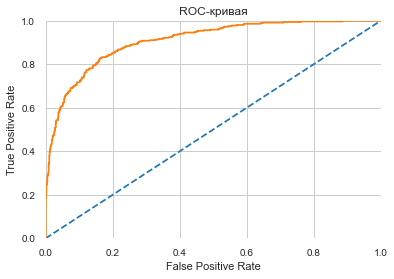

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7464\3969592962.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_scores = df_scores.append(v, ignore_index=True)


In [130]:
v = model_test(xgb.XGBClassifier(random_state=seed),
           [{
    'n_estimators': [20, 50, 120],
    'colsample_bytree': [0.6, 0.8],
    'max_depth': [5, 10, 15],
    'reg_alpha': [1.1, 1.3],
    'reg_lambda': [1.1, 1.3],
    'subsample': [0.7, 0.9]
           }], 
               'XGBClassifier')

df_scores = df_scores.append(v, ignore_index=True)

#### Итоговая таблица 

In [131]:
df_scores = df_scores.sort_values(by = 'roc_auc', ascending = False)
df_scores

,name,params,roc_auc,accuracy,f1,precision,recall,time
3,LGBMClassifier,"LGBMClassifier(class_weight='balanced', colsam...",0.920874,0.852354,0.746634,0.685393,0.819892,12
5,XGBClassifier,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.908276,0.86234,0.709774,0.805461,0.634409,23
0,RandomForestClassifier,"(DecisionTreeClassifier(criterion='entropy', m...",0.861833,0.796719,0.665885,0.590437,0.763441,13
1,DecisionTreeClassifier,DecisionTreeClassifier(class_weight='balanced'...,0.858964,0.784593,0.665188,0.566038,0.806452,1
4,CatBoostClassifier,<catboost.core.CatBoostClassifier object at 0x...,0.856794,0.819544,0.600316,0.727969,0.510753,4266
2,LogisticRegression,"LogisticRegression(C=0.1, class_weight='balanc...",0.839404,0.757489,0.628821,0.529412,0.774194,1


Видим, что на данный момент наилучшая модель LGBMClassifier дает хороший результат на синтетических данных.

#### Вывод 

В данном разделе для обучения были использоваы следующие ML модели: RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, LGBMClassifier, CatBoostClassifier, XGBClassifier. 

Поиск лучших гиперпараметров моделей осуществлялся с помощью RandomizedSearchCV.

Наилучшая модель дала неплохую метрику ROC-AUC. Пришло время проверить модель на тестовой выборке. 

## Тестирование моделей

Напишем функцию для расчета наших метрик и построения графика ROC кривой. 

In [132]:
#функция для AUC-ROC и графика
def auc_roc(model, features_test, target_test):
    
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    predicted_test = model.predict(features_test)
     
    auc_roc_model = roc_auc_score(target_test, probabilities_one_test)
    accuracy = accuracy_score(target_test, predicted_test)
    f1 = f1_score(target_test,predicted_test)
    
    print(f'AUC-ROC лучшей модели на тестовой выборке {auc_roc_model}') 
    print(f'Accuracy лучшей модели на тестовой выборке {accuracy}') 
    print(f'F1 лучшей модели на тестовой выборке: {f1}')
    
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
    %matplotlib inline
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC-кривая')
    plt.show() 

AUC-ROC лучшей модели на тестовой выборке 0.9208737864077668
Accuracy лучшей модели на тестовой выборке 0.8523537803138374
F1 лучшей модели на тестовой выборке: 0.7466340269277846


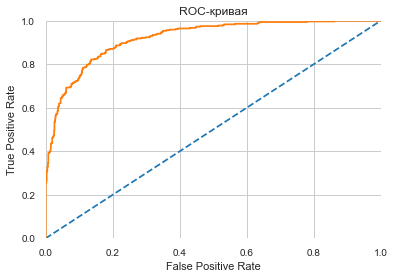

In [133]:
model = df_scores.iloc[0]['params']

auc_roc(model, features_test, target_test)

###  Важность признаков

In [134]:
def importance(model):
    importances = model.feature_importances_
    feature_list = list(features_train.columns)
    feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
    feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

    %matplotlib inline
    fig, ax = plt.subplots(figsize=(16,10))
    feature_results.plot(kind='bar', x='feature', y='importance', ax=ax)
    ax.set_title(f'Важность признаков модели')
    ax.set_ylabel('Важность')
    fig.tight_layout()

    print(feature_results.head(10))

                           feature  importance
0                             days        2488
1                  monthly_charges        1915
2                 tech_support_Yes          58
3                   senior_citizen          51
4            paperless_billing_Yes          50
5            device_protection_Yes          45
6                   dependents_Yes          41
7                    type_One year          34
8  payment_method_Electronic check          34
9              online_security_Yes          33


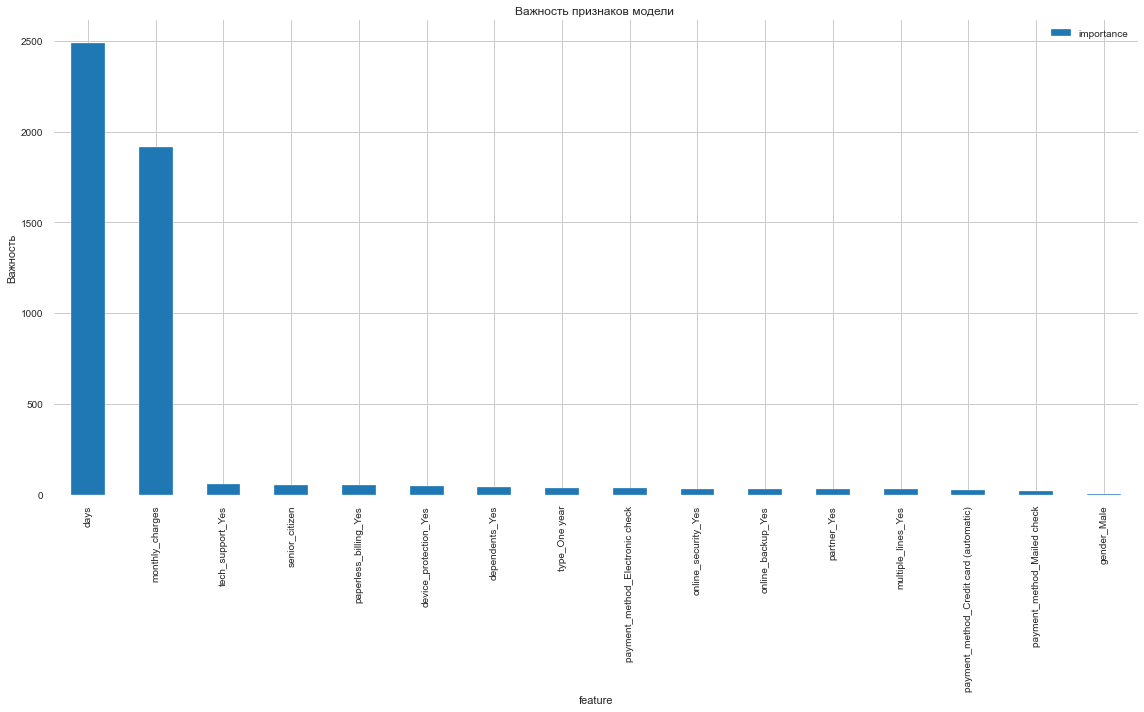

In [135]:
importance(model)

### Удаление маловажных фичей

In [136]:
features = features[['monthly_charges', 'days', 'paperless_billing_Yes', 'tech_support_Yes',
                     'multiple_lines_Yes', 'type_One year']]
target = df['churn']

In [137]:
features

,monthly_charges,days,paperless_billing_Yes,tech_support_Yes,multiple_lines_Yes,type_One year
0,29.85,31,1,0,0,0
1,56.95,1036,0,0,0,1
2,53.85,61,1,0,0,0
3,42.30,1371,0,1,0,1
4,70.70,61,1,0,0,0
...,...,...,...,...,...,...
7004,84.80,730,1,1,1,1
7005,103.20,2191,1,0,1,1
7006,29.60,337,1,0,0,0
7007,74.40,123,1,0,1,0


In [138]:
features_train, features_test, target_train, target_test = train_test_split(
                                                        features,  target, test_size=0.2, random_state=250722, stratify=target)

In [139]:
features_train.shape, features_test.shape, 

((5607, 6), (1402, 6))

In [140]:
target_train.mean(), target_test.mean()

(0.2655609060103442, 0.2653352353780314)

In [141]:
numeric = ['monthly_charges', 'days']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.head(10)) 

      monthly_charges      days  paperless_billing_Yes  tech_support_Yes  \
2613         0.466521  1.564370                      1                 1   
5846        -0.312023 -0.355689                      1                 0   
2029         0.184319 -1.292270                      1                 0   
1462         0.288900 -0.393206                      1                 1   
1783         0.433321 -0.844748                      0                 0   
550          1.678326  1.601887                      1                 1   
4293        -0.479684 -0.434742                      1                 0   
3600        -0.497944  0.911845                      1                 0   
3789         0.964523  1.154365                      1                 1   
5526         1.090684 -1.210537                      1                 1   

      multiple_lines_Yes  type_One year  
2613                   0              0  
5846                   1              0  
2029                   0             

In [142]:
#функция для AUC-ROC и графика
def auc_roc_new(model, features_train, target_train, features_test, target_test):
    
    model.fit(features_train, target_train)
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    predicted_test = model.predict(features_test)
     
    auc_roc_model = roc_auc_score(target_test, probabilities_one_test)
    accuracy = accuracy_score(target_test, predicted_test)
    f1 = f1_score(target_test,predicted_test)
    
    print(f'AUC-ROC лучшей модели на тестовой выборке {auc_roc_model}') 
    print(f'Accuracy лучшей модели на тестовой выборке {accuracy}') 
    print(f'F1 лучшей модели на тестовой выборке: {f1}')
    
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
    %matplotlib inline
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC-кривая')
    plt.show() 

AUC-ROC лучшей модели на тестовой выборке 0.9246607161499113
Accuracy лучшей модели на тестовой выборке 0.8509272467902995
F1 лучшей модели на тестовой выборке: 0.7448107448107449


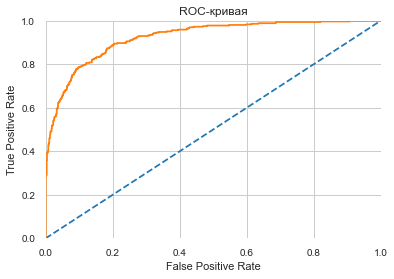

In [143]:
auc_roc_new(model, features_train, target_train,  features_test, target_test)

                 feature  importance
0                   days        2653
1        monthly_charges        1683
2          type_One year          48
3  paperless_billing_Yes          42
4     multiple_lines_Yes          41
5       tech_support_Yes          27


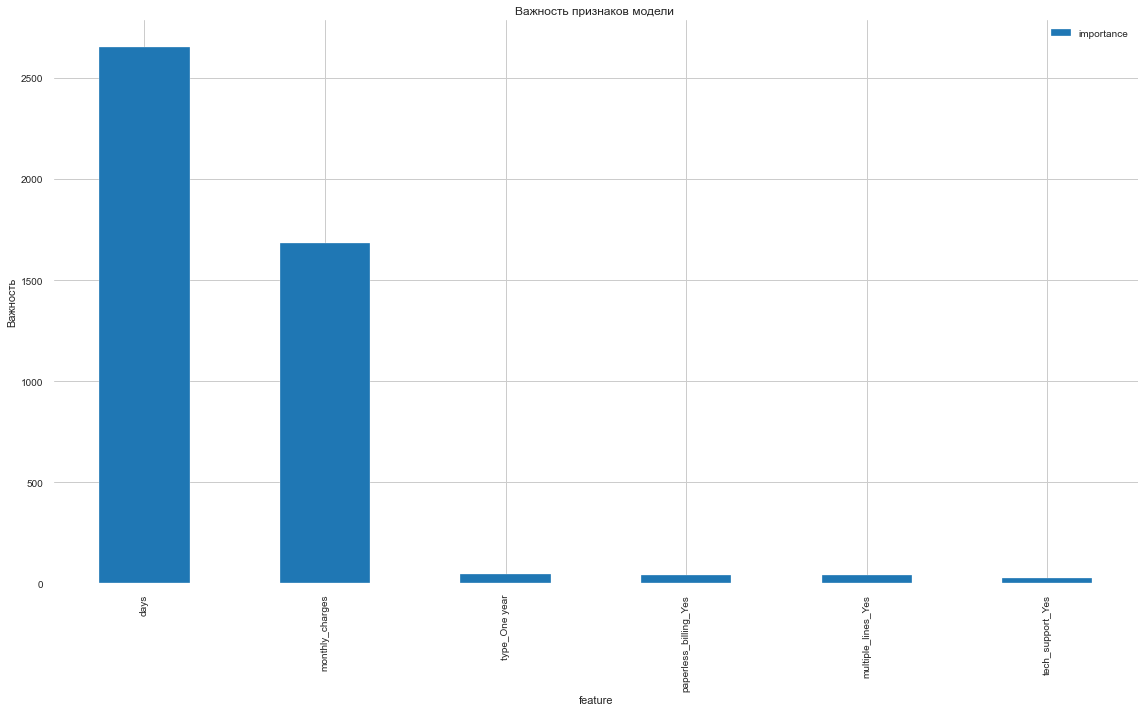

In [144]:
importance(model)

Стало немного лучше. 

### Удаление маловажных фичей 2

Попробууем оставить только ДВЕ самые важные для модели фичи и посмотрим, как это повлияет на итоговую оценку ROC-AUC.

In [145]:
features = features[['monthly_charges', 'days']]
target = df['churn']

In [146]:
features

,monthly_charges,days
0,29.85,31
1,56.95,1036
2,53.85,61
3,42.30,1371
4,70.70,61
...,...,...
7004,84.80,730
7005,103.20,2191
7006,29.60,337
7007,74.40,123


In [147]:
features_train, features_test, target_train, target_test = train_test_split(
                                                        features,  target, test_size=0.2, random_state=250722, stratify=target)

In [148]:
features_train.shape, features_test.shape, 

((5607, 2), (1402, 2))

In [149]:
target_train.mean(), target_test.mean()

(0.2655609060103442, 0.2653352353780314)

In [150]:
numeric = ['monthly_charges', 'days']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.head(10)) 

      monthly_charges      days
2613         0.466521  1.564370
5846        -0.312023 -0.355689
2029         0.184319 -1.292270
1462         0.288900 -0.393206
1783         0.433321 -0.844748
550          1.678326  1.601887
4293        -0.479684 -0.434742
3600        -0.497944  0.911845
3789         0.964523  1.154365
5526         1.090684 -1.210537


AUC-ROC лучшей модели на тестовой выборке 0.9265372168284789
Accuracy лучшей модели на тестовой выборке 0.8388017118402282
F1 лучшей модели на тестовой выборке: 0.7270531400966184


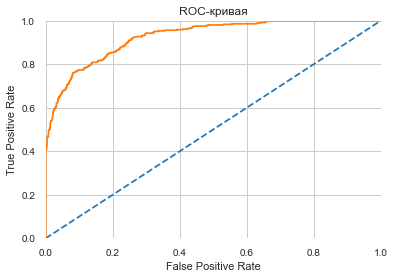

In [151]:
auc_roc_new(model, features_train, target_train,  features_test, target_test)

In [152]:
#функция для AUC-ROC и графика
def auc_roc_new(model, features_train, target_train, features_test, target_test):
    
    model.fit(features_train, target_train)
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    predicted_test = model.predict(features_test)
     
    auc_roc_model = roc_auc_score(target_test, probabilities_one_test)
    accuracy = accuracy_score(target_test, predicted_test)
    f1 = f1_score(target_test,predicted_test)
    
    print(f'AUC-ROC лучшей модели на тестовой выборке {auc_roc_model}') 
    print(f'Accuracy лучшей модели на тестовой выборке {accuracy}') 
    print(f'F1 лучшей модели на тестовой выборке: {f1}')
    
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
    %matplotlib inline
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC-кривая')
    plt.show() 

           feature  importance
0             days        2861
1  monthly_charges         978


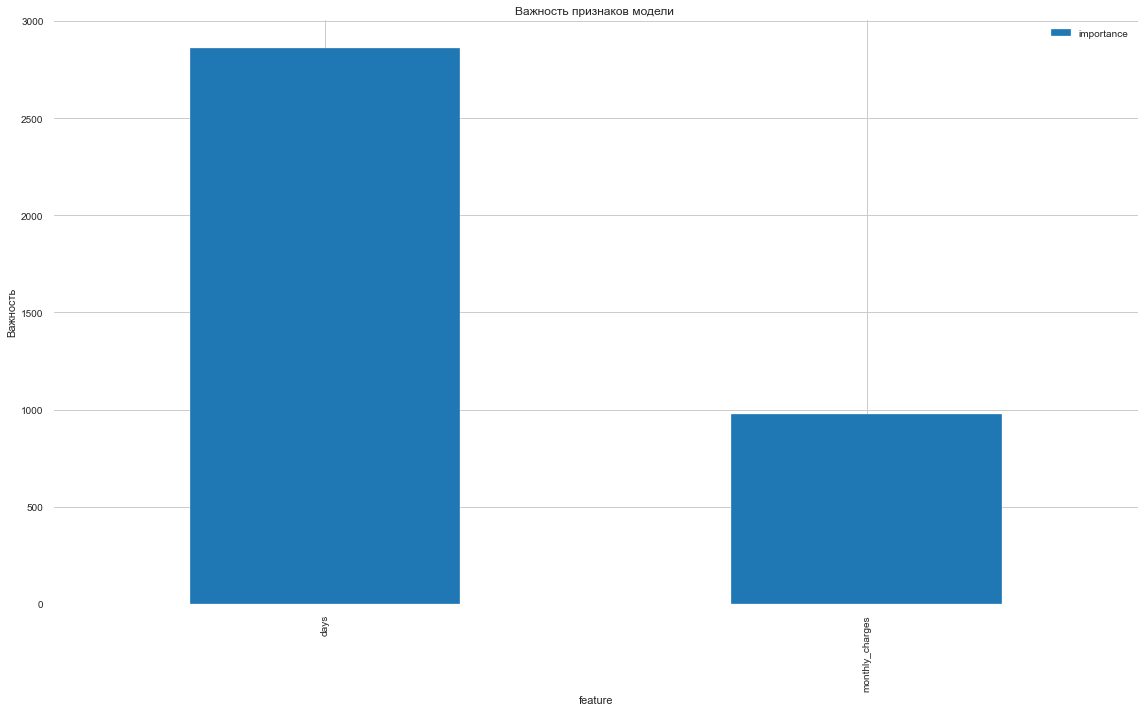

In [153]:
importance(model)

### Вывод

Видим, что с двумя признаками модель работает немного хуже, чем с шестью, но даже чуть лучше, чем с 22 признаками. 
Много признаков засоряют эфир =)

## Вывод

В результате проекта, нам удалось построить модель, которая определяет факт ухода клиента. ROC-AUC = 0.92. f1 = 0.74

В результате корректировок удалось несущественно изменить метрику качества. 
Убрав неважные признаки, модель стала работать лучше, а важность признаков не исчезла. 

С учетом того, что с большой долей вероятности клиент, имеющий оптоволоконный интернет уйдет, оператору связи стоит задуматьмя либо над уменьшением стоимости услуг, либо над повышением их качества. 
Ну и, конечно, рассылка промо-предложенией и акций спасет мир. 